# Introduction

### Authors: Zain Ali, Halladay Kinsey, and Hani Jandali

Welcome to the Jupyter notebook for our project "SmartSensory: An IoT Time Series Prediction Model for Behavioral Monitoring." This notebook is an integral part of our repository, which delves into analyzing smartphone sensor data from 60 unique users to develop predictive models that monitor behavior through time series analysis.

In this notebook, we walk through our data preparation and manipulation process, showcasing our approach to cleaning and combining individual user data into a comprehensive dataset named "ExtraSensory_Combined_User_Data." Our journey in this notebook spans from initial data exploration to the application of various predictive models, illustrating our iterative process in refining and evaluating these models.

Our primary focus is on the ExtraSensory Dataset, a rich collection of smartphone and smartwatch sensor data, complemented by user-validated context labels. We meticulously prepare this data, emphasizing a 0% missing value threshold and excluding smartwatch data to enhance the dataset's relevance and reduce computational complexity.

Through this notebook, you will gain insights into our data analysis techniques and the rationale behind our model choices, particularly our use of classifier chains and LSTM networks. We also compare these approaches with a linear model that leverages label predictions to forecast sensor inputs.

Join us as we navigate through the intricate process of transforming raw sensor data into meaningful insights for behavioral monitoring, underpinning the potential of IoT applications in real-world scenarios.

# Data Information

The ExtraSensory Dataset is a collection of data aimed at understanding detailed human contexts using data from smartphones and smartwatches. It was developed by Yonatan Vaizman and Katherine Ellis under the guidance of Gert Lanckriet at the University of California, San Diego's Department of Electrical and Computer Engineering. The dataset is freely available for research purposes, with the condition that any publication using it cites the foundational paper by Vaizman, Ellis, and Lanckriet published in IEEE Pervasive Computing in 2017.

The dataset includes 60 compressed CSV files, one for each participant, identified by a unique UUID. Each file contains rows of data examples timestamped and sorted, with the following main columns:

1. **Timestamp**: The first column shows the timestamp in seconds since the epoch.
2. **Features**: Following the timestamp, there are various feature columns derived from different sensors like the accelerometer, gyroscope, magnetometer on the phone, and additional sensors on the watch. These features include raw and processed data points from each sensor.
3. **Ground Truth Labels**: The dataset includes labeled data indicating the user's context at the time of data collection. These labels are binary, showing whether a particular label applies to an example, and include original labels from the app interface, cleaned or fixed labels by researchers, and synthesized labels created by combining related labels.
4. **Label Source**: The final column indicates the source of the labeling, showing how the user interacted with the app to provide context information, such as active feedback, historical labeling, or responses to notifications.


In [63]:
# Standard library imports
import gzip
import os
import shutil
import zipfile
import pickle
from threading import Timer

# Data handling and numerical analysis
import pandas as pd
import numpy as np

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

# Machine Learning and Deep Learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, clone_model
from tensorflow.keras.layers import (Dense, Dropout, LSTM, Conv1D, MaxPooling1D,
                                     Flatten, BatchNormalization, Reshape, Bidirectional)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.sequence import pad_sequences, TimeseriesGenerator

# Sklearn for model evaluation and preprocessing
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, mean_squared_error)
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from skmultilearn.problem_transform import ClassifierChain

# PyTorch for alternative deep learning model construction
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Miscellaneous
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Data Consolidation
This section focuses on the process of combining data from multiple sources into a single, unified dataset. It involves unzipping data files, extracting CSV files from the zipped archives, and merging these CSV files. The goal is to create a comprehensive dataset that facilitates easier data manipulation and analysis.


In [3]:
# Making sure ExtraSensory.per_uuid_features_labels.zip exists and is unziped
def unzip(zip_file):
    # Extract to the directory obtained from the zip file name
    zip_extract_to = zip_file.replace('.zip', '')

    # Unzipping
    if os.path.exists(zip_file):
        if not os.path.exists(zip_extract_to):
            os.makedirs(zip_extract_to)
            with zipfile.ZipFile(zip_file, 'r') as zip_ref:
                zip_ref.extractall(zip_extract_to)
            message = "Unzipped successfully."
        else:
            message = "Directory already exists. File might be unzipped."
    else:
        message = "Zip file not found."

    print(message)
    return zip_extract_to


def csv_extract(zip_extract_to):
    # Improved variable name for the directory where the extracted files will be saved
    unzipped_data_dir = f"{zip_extract_to}-Unzipped"

    # Create the unzipped data directory if it does not exist
    if not os.path.exists(unzipped_data_dir):
        os.makedirs(unzipped_data_dir)

    # Extracting .csv.gz files
    extraction_message = ""
    if os.path.exists(zip_extract_to):
        for file in os.listdir(zip_extract_to):
            if file.endswith('.gz'):
                gz_file_path = os.path.join(zip_extract_to, file)
                csv_file_path = os.path.join(unzipped_data_dir, file[:-3])  # Removing '.gz' from filename

                try:
                    with gzip.open(gz_file_path, 'rb') as f_in:
                        with open(csv_file_path, 'wb') as f_out:
                            shutil.copyfileobj(f_in, f_out)
                    extraction_message += f"Extracted {file}\n"
                except Exception as e:
                    extraction_message += f"Error extracting {file}: {e}\n"
    else:
        extraction_message = "Directory with .gz files not found."

    print(extraction_message.strip())

    return unzipped_data_dir


# Function to extract user_id from filename
def extract_user_id(filename):
    return filename.split('.')[0]

def make_one_csv(unzipped_data_dir, COMBINED_FILE):
    # Combining all CSVs into one dataframe
    combined_csv_data = pd.DataFrame()

    if os.path.exists(unzipped_data_dir):
        for file in os.listdir(unzipped_data_dir):
            if file.endswith('.csv'):
                file_path = os.path.join(unzipped_data_dir, file)
                user_id = extract_user_id(file)

                # Read the CSV file and add the user_id column
                csv_data = pd.read_csv(file_path)
                csv_data['user_id'] = user_id

                # Append to the combined dataframe
                combined_csv_data = pd.concat([combined_csv_data, csv_data], ignore_index=True)

                
                #print(f"Processed file: {file} \nCurrent size of combined data: {combined_csv_data.shape}")


        # Check if any data has been combined
        if not combined_csv_data.empty:
            # Save the combined CSV data to a file
            combined_csv_data.to_csv(COMBINED_FILE, index=False)
            print(f"Combined CSV file created at {COMBINED_FILE}.")
        else:
            print("No CSV files found to combine or combined data is empty.")
    else:
        print("Directory with unzipped CSV files not found.")
    return COMBINED_FILE



In [4]:
COMBINED_FILE = 'ExtraSensory_Combined_User_Data.csv'
if not os.path.exists(COMBINED_FILE):
    # Path of the zip file
    zip_file = 'ExtraSensory.per_uuid_features_labels.zip'
    zip_extract_to = unzip(zip_file)
    unzipped_data_dir = csv_extract(zip_extract_to)
    make_one_csv(unzipped_data_dir, COMBINED_FILE)
else:
    print('Combined file already exists.')


Combined file already exists.


# Data Exploration & Models Creation

In [5]:
combined_csv_data = pd.read_csv(COMBINED_FILE)
combined_csv_data['timestamp'] = pd.to_datetime(combined_csv_data['timestamp'], unit='s')

In [6]:
print(combined_csv_data.columns)

# user_id is for us to make sure we have record on source of the data. 

Index(['timestamp', 'raw_acc:magnitude_stats:mean',
       'raw_acc:magnitude_stats:std', 'raw_acc:magnitude_stats:moment3',
       'raw_acc:magnitude_stats:moment4',
       'raw_acc:magnitude_stats:percentile25',
       'raw_acc:magnitude_stats:percentile50',
       'raw_acc:magnitude_stats:percentile75',
       'raw_acc:magnitude_stats:value_entropy',
       'raw_acc:magnitude_stats:time_entropy',
       ...
       'label:ELEVATOR', 'label:OR_standing', 'label:AT_SCHOOL',
       'label:PHONE_IN_HAND', 'label:PHONE_IN_BAG', 'label:PHONE_ON_TABLE',
       'label:WITH_CO-WORKERS', 'label:WITH_FRIENDS', 'label_source',
       'user_id'],
      dtype='object', length=279)


In [7]:
# Trying to understand columns
def build_hierarchy(columns):
    # Build a nested dictionary representing the hierarchy of columns.
    hierarchy = {}
    for col in columns:
        parts = col.split(':')
        current_level = hierarchy

        for part in parts[:-1]:
            current_level = current_level.setdefault(part, {})
        
        current_level[parts[-1]] = col

    return hierarchy

def format_hierarchy(hierarchy, indent=0):
    # Format the hierarchy into a readable string with indentation.
    result = ""
    for key, value in hierarchy.items():
        prefix = "  " * indent + "- "
        if isinstance(value, dict):
            result += f"{prefix}{key}:\n{format_hierarchy(value, indent + 1)}"
        else:
            result += f"{prefix} {key}\n"
    return result

# Building and formatting the hierarchy
hierarchy = build_hierarchy(combined_csv_data.columns)
formatted_hierarchy = format_hierarchy(hierarchy)
print(formatted_hierarchy)

-  timestamp
- raw_acc:
  - magnitude_stats:
    -  mean
    -  std
    -  moment3
    -  moment4
    -  percentile25
    -  percentile50
    -  percentile75
    -  value_entropy
    -  time_entropy
  - magnitude_spectrum:
    -  log_energy_band0
    -  log_energy_band1
    -  log_energy_band2
    -  log_energy_band3
    -  log_energy_band4
    -  spectral_entropy
  - magnitude_autocorrelation:
    -  period
    -  normalized_ac
  - 3d:
    -  mean_x
    -  mean_y
    -  mean_z
    -  std_x
    -  std_y
    -  std_z
    -  ro_xy
    -  ro_xz
    -  ro_yz
- proc_gyro:
  - magnitude_stats:
    -  mean
    -  std
    -  moment3
    -  moment4
    -  percentile25
    -  percentile50
    -  percentile75
    -  value_entropy
    -  time_entropy
  - magnitude_spectrum:
    -  log_energy_band0
    -  log_energy_band1
    -  log_energy_band2
    -  log_energy_band3
    -  log_energy_band4
    -  spectral_entropy
  - magnitude_autocorrelation:
    -  period
    -  normalized_ac
  - 3d:
    -  me

In [8]:
# List of label columns to check
label_columns = [col for col in combined_csv_data.columns if col.startswith("label:")]

# Assumption of zeros for the labels
combined_csv_data[label_columns] = combined_csv_data[label_columns].fillna(0)

combined_csv_data['label_sum_inital'] = combined_csv_data[label_columns].sum(axis=1)
combined_csv_data['label:UNKNOWN'] = (combined_csv_data['label_sum_inital'] == 0).astype(float)
label_columns.append('label:UNKNOWN')
combined_csv_data = combined_csv_data.drop('label_sum_inital', axis=1)
df = combined_csv_data.copy()


# Function to find the label name with value 1
def find_label_name(row):
    for col in label_columns:
        if row[col] == 1:
            return col.split("label:")[1]
    return None

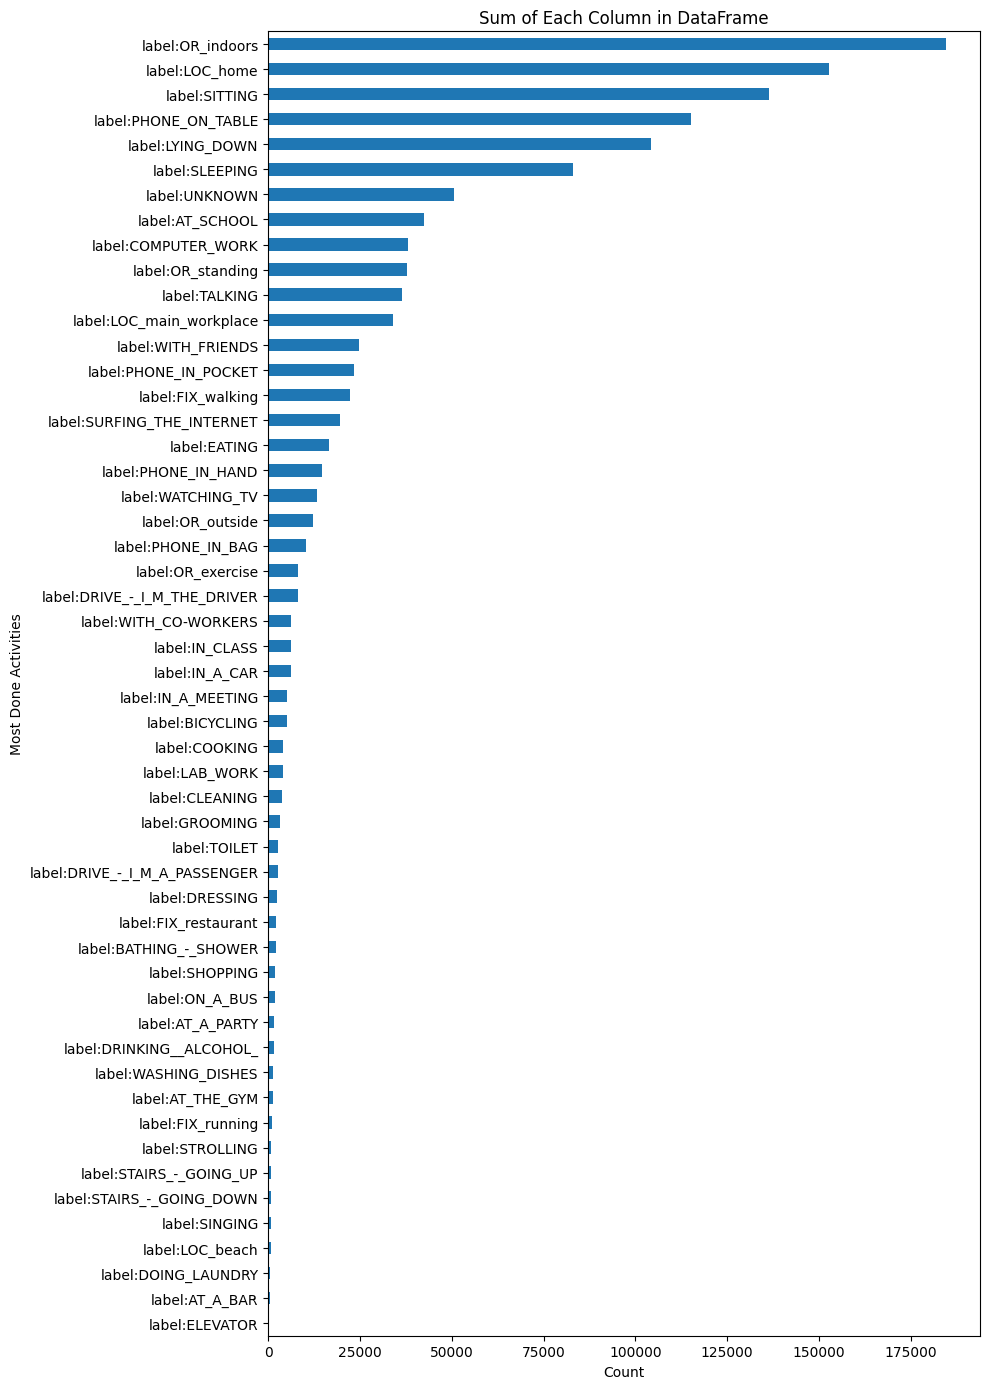

In [9]:
# Checking ground truth labels for value counts
column_sums = df[label_columns].sum()
column_sums_sorted = column_sums.sort_values(ascending=True)

# Plot setup
plt.figure(figsize=(10, 14)) 
column_sums_sorted.plot(kind='barh')
plt.title('Sum of Each Column in DataFrame')
plt.xlabel('Count')
plt.ylabel('Most Done Activities')
plt.tight_layout()
plt.show()

In [10]:
# Categorizing Important Columns
unneeded_columns = ['user_id', 'label_source']
output_columns = [col for col in combined_csv_data.columns if col.startswith('label:')]
input_columns = [col for col in combined_csv_data.columns if col not in output_columns and col not in unneeded_columns]
X_main = df.copy()[input_columns]

### Missing Value Solution

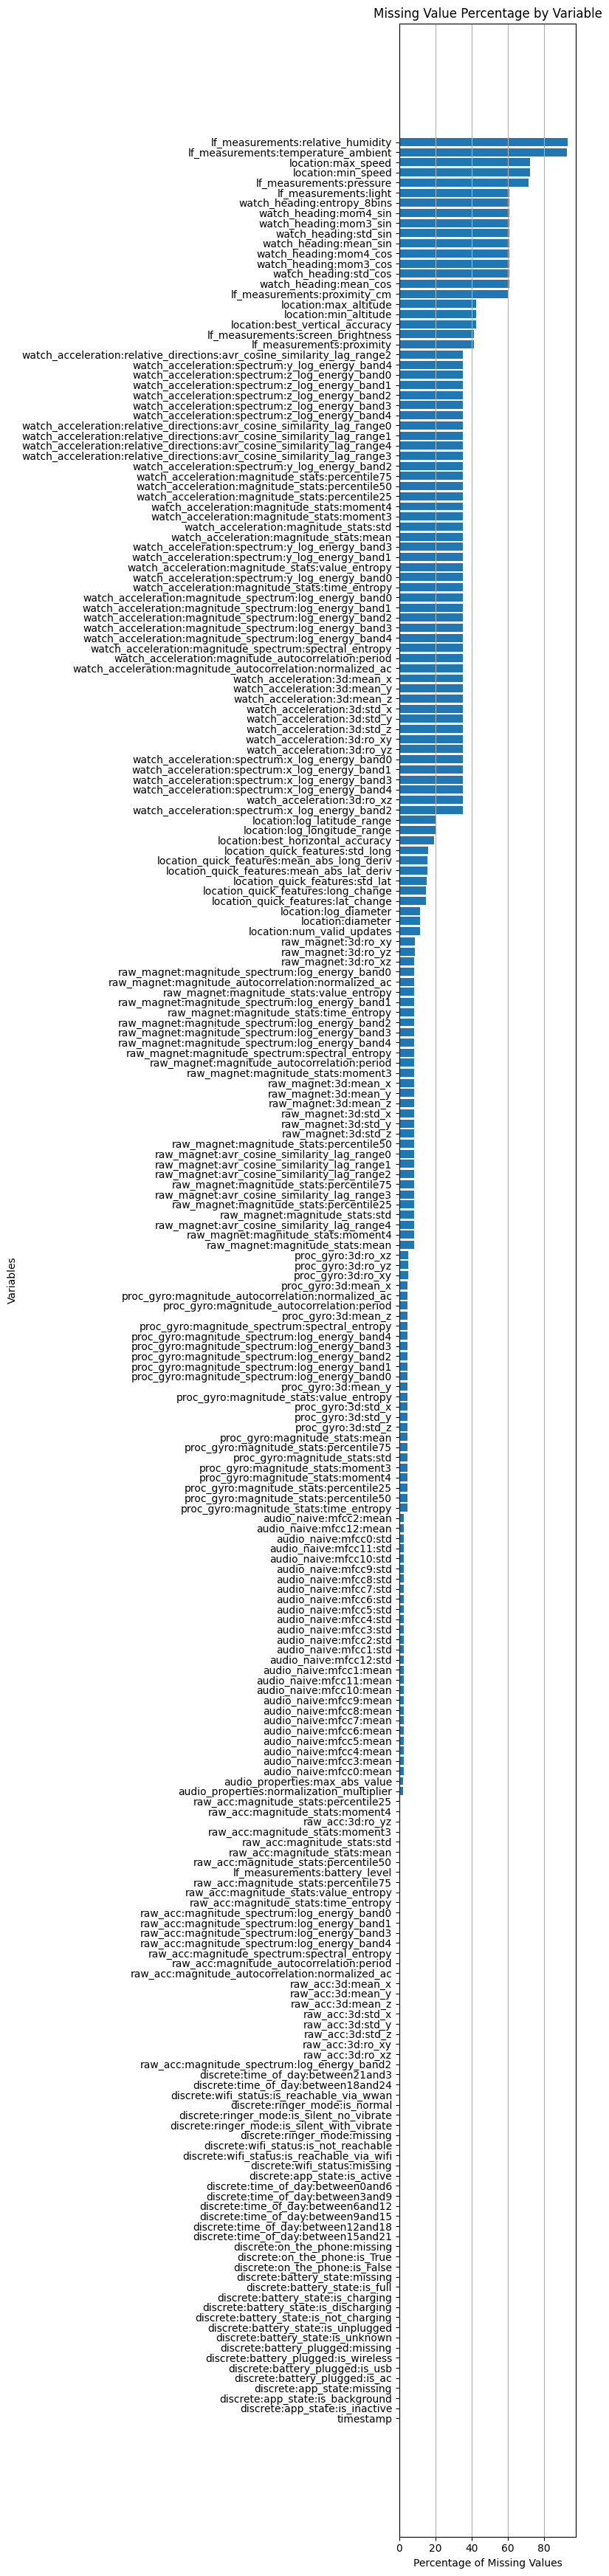

In [11]:
# Checking input variables for missing values
def nan_percentage(df):
    nan_percentage = (df.isna().mean() * 100).round(2)
    nan_percentage_df = pd.DataFrame({'Variable': nan_percentage.index, 'NaN Percentage': nan_percentage.values})
    nan_percentage_df = nan_percentage_df.sort_values(by='NaN Percentage', ascending=True)
    
    # Plot setup
    plt.figure(figsize=(8, 35)) 
    plt.barh(nan_percentage_df['Variable'], nan_percentage_df['NaN Percentage'])
    plt.xlabel('Percentage of Missing Values')
    plt.ylabel('Variables')
    plt.title('Missing Value Percentage by Variable')
    plt.grid(axis='x')
    plt.tight_layout() 
    plt.show()
    return nan_percentage_df

# Checking overall missing percentage
nan_percentage_df = nan_percentage(X_main)

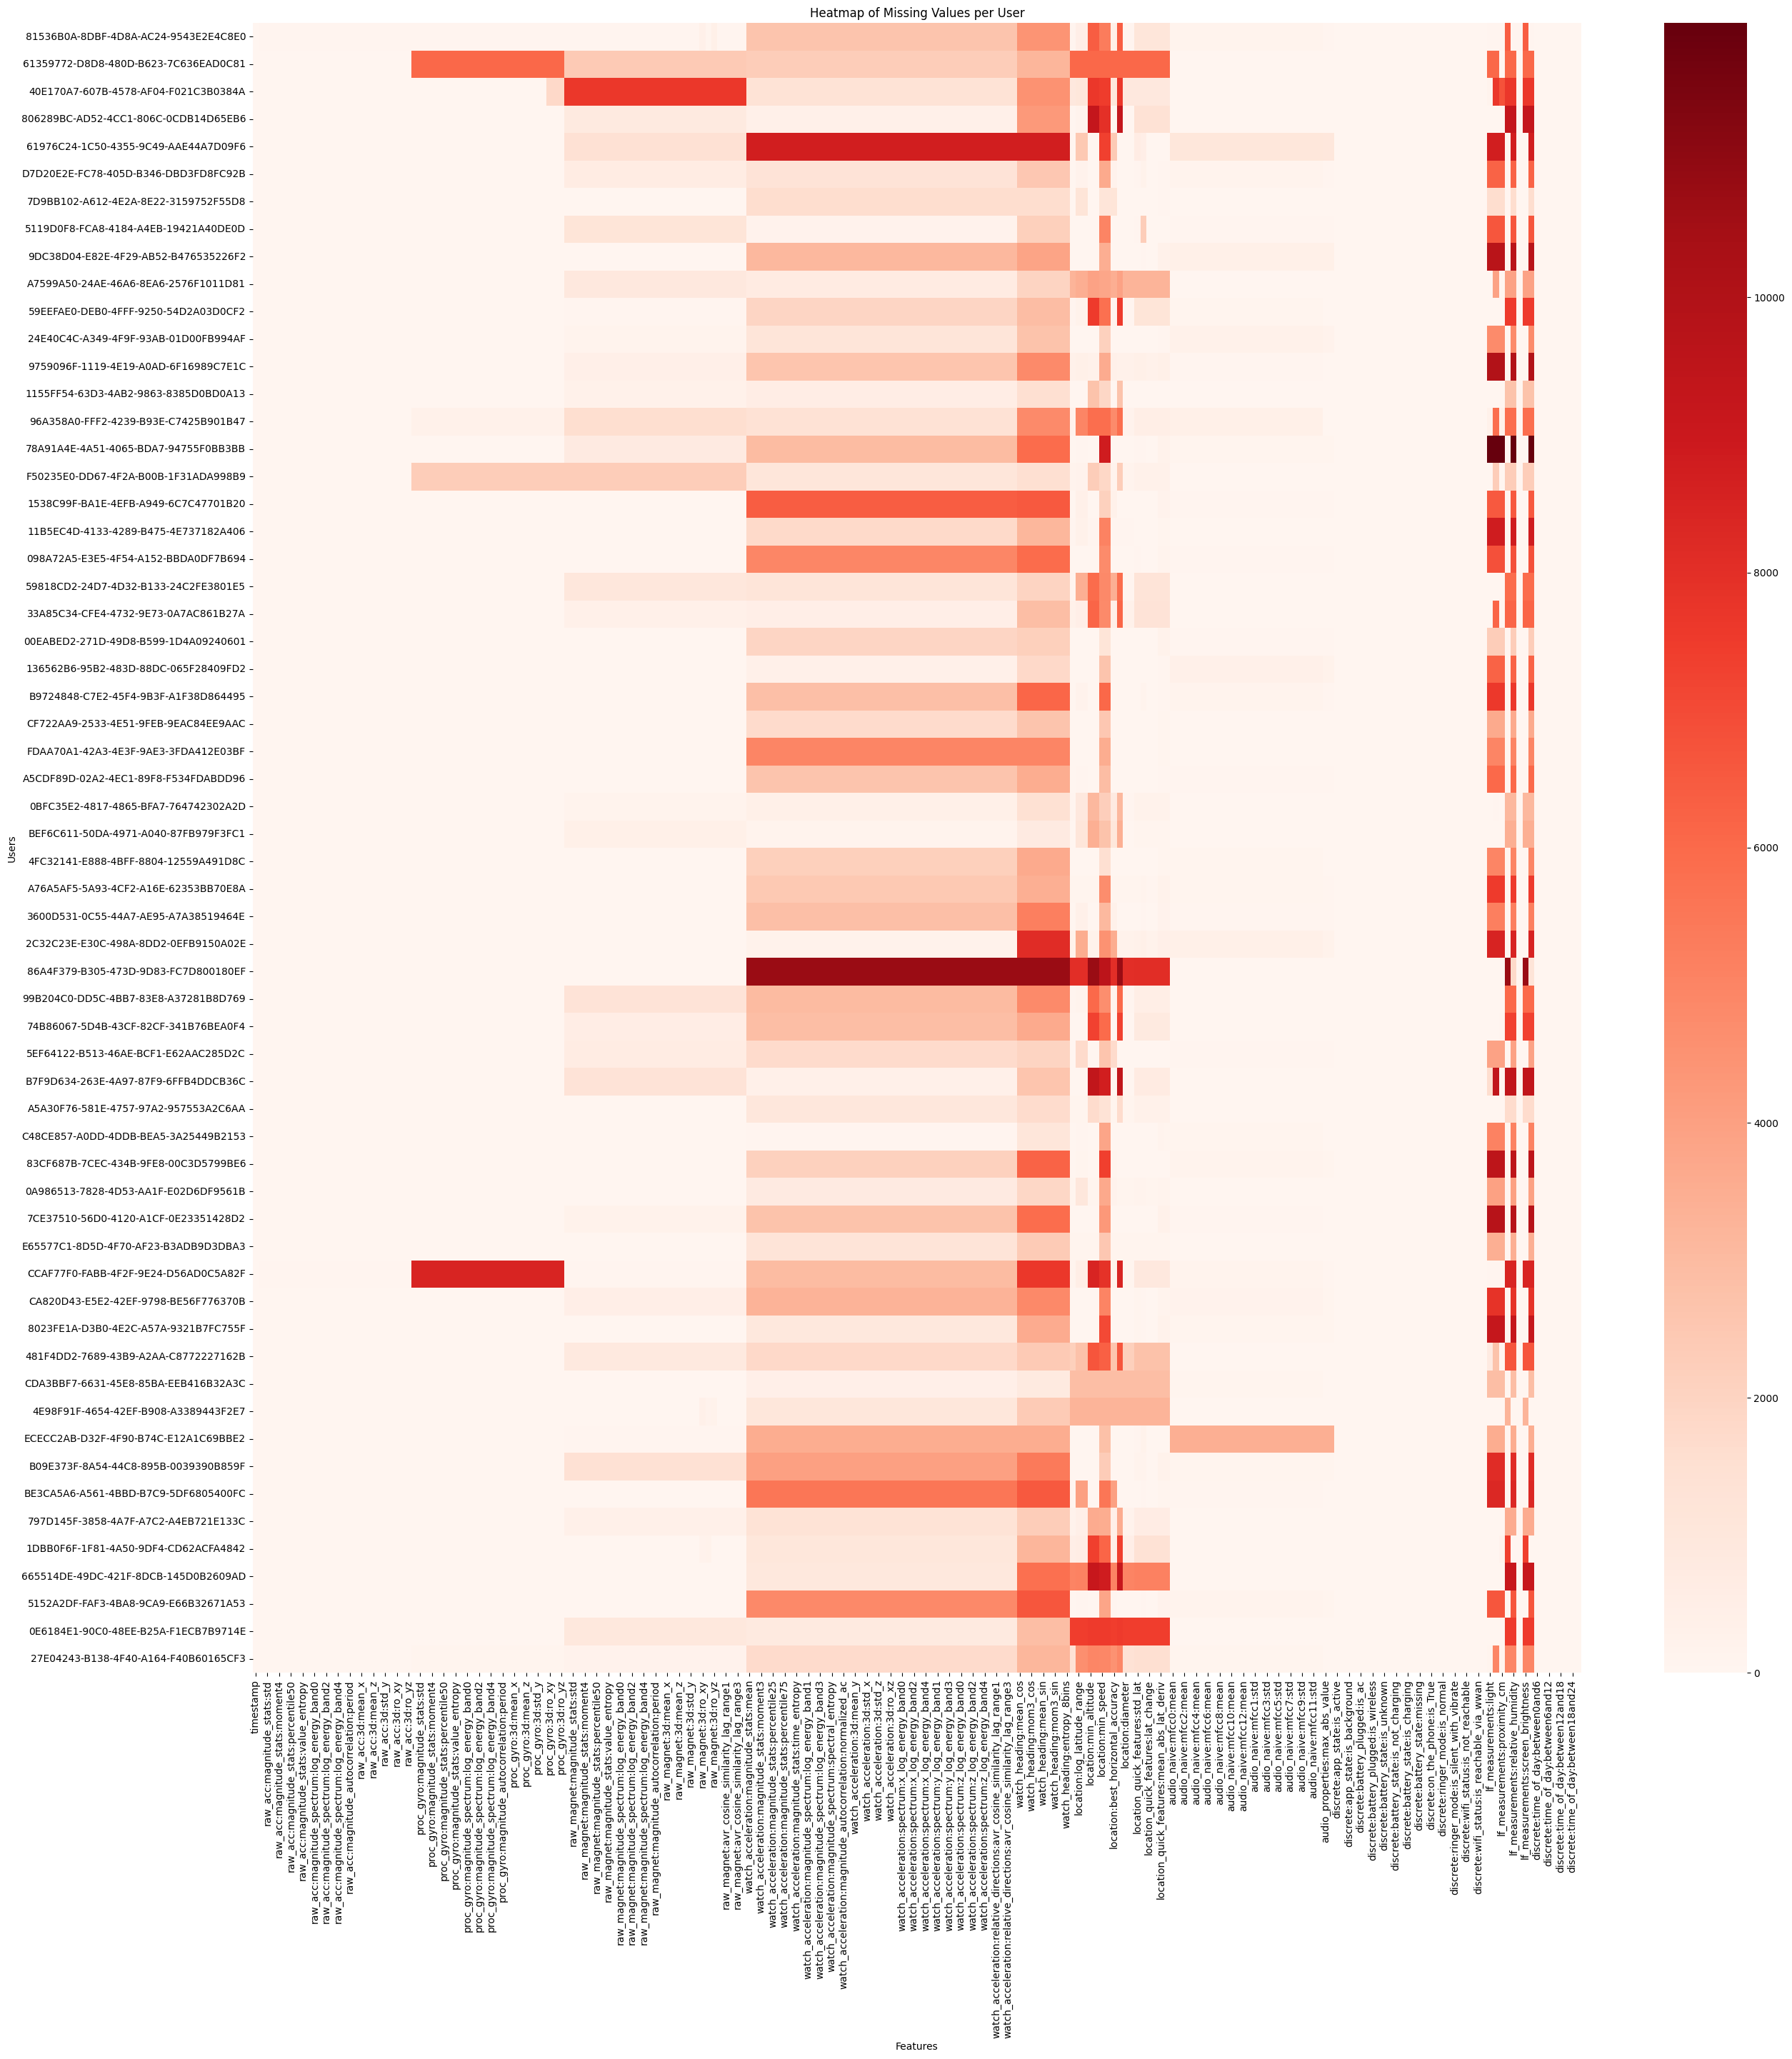

In [12]:
X_with_users = df.drop(columns=['label_source'])
users = X_with_users['user_id'].unique()
features = input_columns

# Initialize a list to store the counts for each user
nan_counts_list = []

# Loop through each user
for user in users:
    # Filter the DataFrame for the current user
    df_user = X_with_users[X_with_users['user_id'] == user]
    
    # Count the NaN values for each feature for the current user and add user_id to the series
    nan_count = df_user[features].isna().sum()
    nan_count['user_id'] = user  # Add user_id to the count
    
    # Append the count series to the list
    nan_counts_list.append(nan_count)

# Convert the list of Series to a DataFrame
nan_counts_per_user = pd.DataFrame(nan_counts_list)

# If needed, set the user_id as the index
nan_counts_per_user.set_index('user_id', inplace=True)


# Plot the heat map
plt.figure(figsize=(30, 30))
sns.heatmap(nan_counts_per_user, annot=False, cmap='Reds')
plt.title('Heatmap of Missing Values per User')
plt.xlabel('Features')
plt.ylabel('Users')
plt.show()

In [13]:
# Calculate the total number of rows for each user in the original DataFrame
user_total_length = X_with_users.groupby('user_id').size()

# Convert this to a DataFrame or a Series that can be added to nan_counts_per_user
user_total_length_df = user_total_length.to_frame(name='total_length')

# Merge this information with nan_counts_per_user
# Since nan_counts_per_user already has user_id as its index, we can directly add the new column
nan_counts_per_user['total_length'] = user_total_length_df['total_length']

# Now, nan_counts_per_user includes the total_length column

In [14]:

# Calculate the total NaN count for each feature across all users
total_nan_counts = nan_counts_per_user.sum()

# Assuming `X_with_users` is your original DataFrame and has the same number of entries for each user,
# Calculate the total number of entries for a single feature across all users
total_entries_per_feature = len(X_with_users)  # Or, more specifically, len(users) * average_entries_per_user if varies

# Calculate the percentage of missing data for each feature
percentage_missing = (total_nan_counts / total_entries_per_feature) * 100


# Decide on a threshold for removing columns, e.g., 1%
threshold = 0

# Identify columns that exceed this threshold
columns_to_remove = percentage_missing[percentage_missing > threshold].index.tolist()

print("Removing ", len(columns_to_remove),"columns out of ", len(X_with_users.columns))
# Print out the columns to remove
# print("Columns to remove due to excessive missing data:", columns_to_remove)

features_to_include = [feature for feature in features if feature not in columns_to_remove]

if 'timestamp' in X_with_users.columns:
    X_with_users['timestamp_numeric'] = X_with_users['timestamp'].astype(np.int64) // 10**9
    # Ensure 'timestamp_numeric' is included and 'timestamp' is excluded from features_to_include
    features_to_include = [f for f in features_to_include if f != 'timestamp'] + ['timestamp_numeric']

# Continue with your existing preprocessing...
user_df = X_with_users[X_with_users['user_id'] == users[-1]]
median_values = user_df[features_to_include].median()
user_df = user_df[features_to_include].fillna(median_values)


Removing  192 columns out of  279


We performed a threshold check from 0 to 5 percent, testing each percentage, and then proceeded with increments of 5. Each test was conducted with a classifier and a linear model, where 0% consistently performed the best. We also evaluated several LSTM models and the standard techniques of forward fill, mean, median, and mode to address missing values. The median emerged as the second-best method, with the most effective approach being to ignore the values using a threshold of 0.

#### Classifier Detail Check
Testing to see if we need to do Binary Relevance, or Classifier chains. We can also check Label Powerset, but the issue is combinations can become very large since we have 52 labels. 

In [15]:
combined_csv_data_4_model = combined_csv_data.copy()
combined_csv_data_4_model['timestamp_numeric'] = combined_csv_data_4_model['timestamp'].astype(np.int64) // 10**9
combined_csv_data_4_model = combined_csv_data_4_model.drop(columns=['timestamp'])
X = combined_csv_data_4_model[features_to_include]
y = combined_csv_data_4_model[output_columns]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

<Figure size 2000x2000 with 0 Axes>

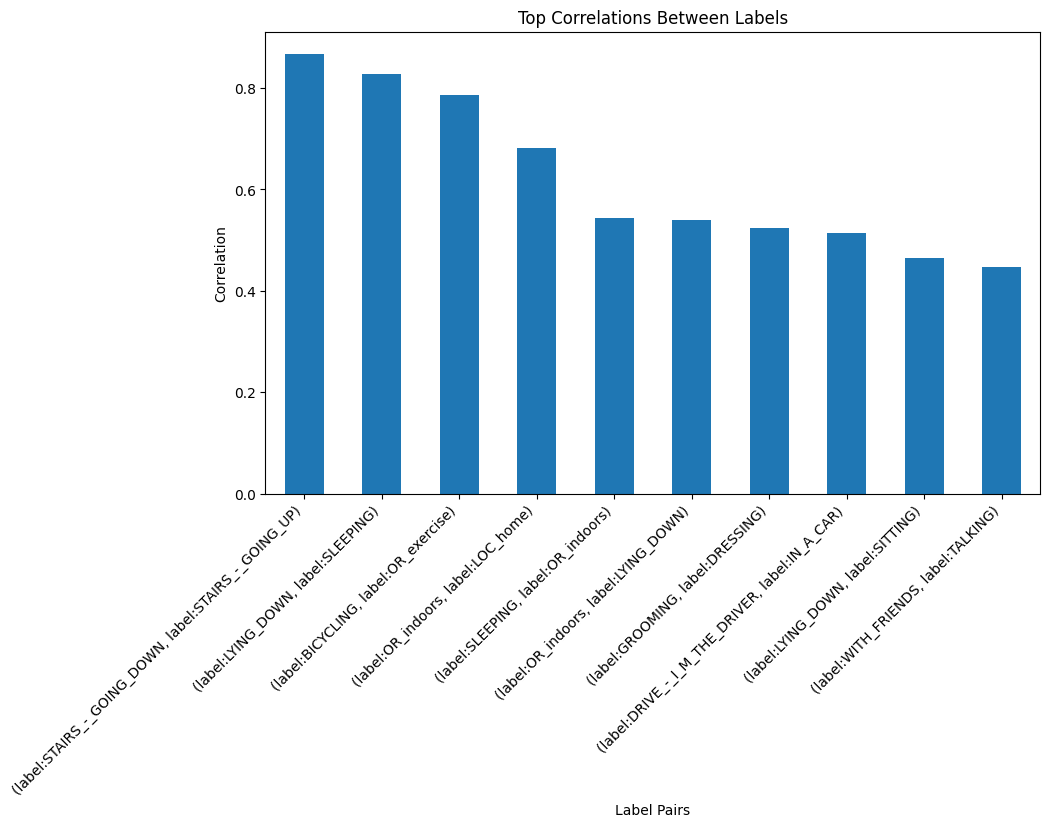

In [16]:
plt.figure(figsize = (20,20))
corr_matrix = y.corr(method = 'pearson')  # Compute the correlation matrix

# Flatten the matrix, sort by absolute value while preserving names
corr_flat = corr_matrix.unstack()
corr_flat_sorted = corr_flat.abs().sort_values(ascending=False)

# Remove self-correlations
corr_flat_sorted = corr_flat_sorted[corr_flat_sorted < 1]

# Take the top N correlations for plotting (for simplicity, let's plot all unique pairs)
unique_pairs = corr_flat_sorted.drop_duplicates().head(10)

# Plotting
plt.figure(figsize=(10, 6))
unique_pairs.plot(kind='bar')
plt.title('Top Correlations Between Labels')
plt.xlabel('Label Pairs')
plt.ylabel('Correlation')
plt.xticks(rotation=45, ha='right')
plt.show()

Seems like there is a corrolation, lets do Classifier chains. 

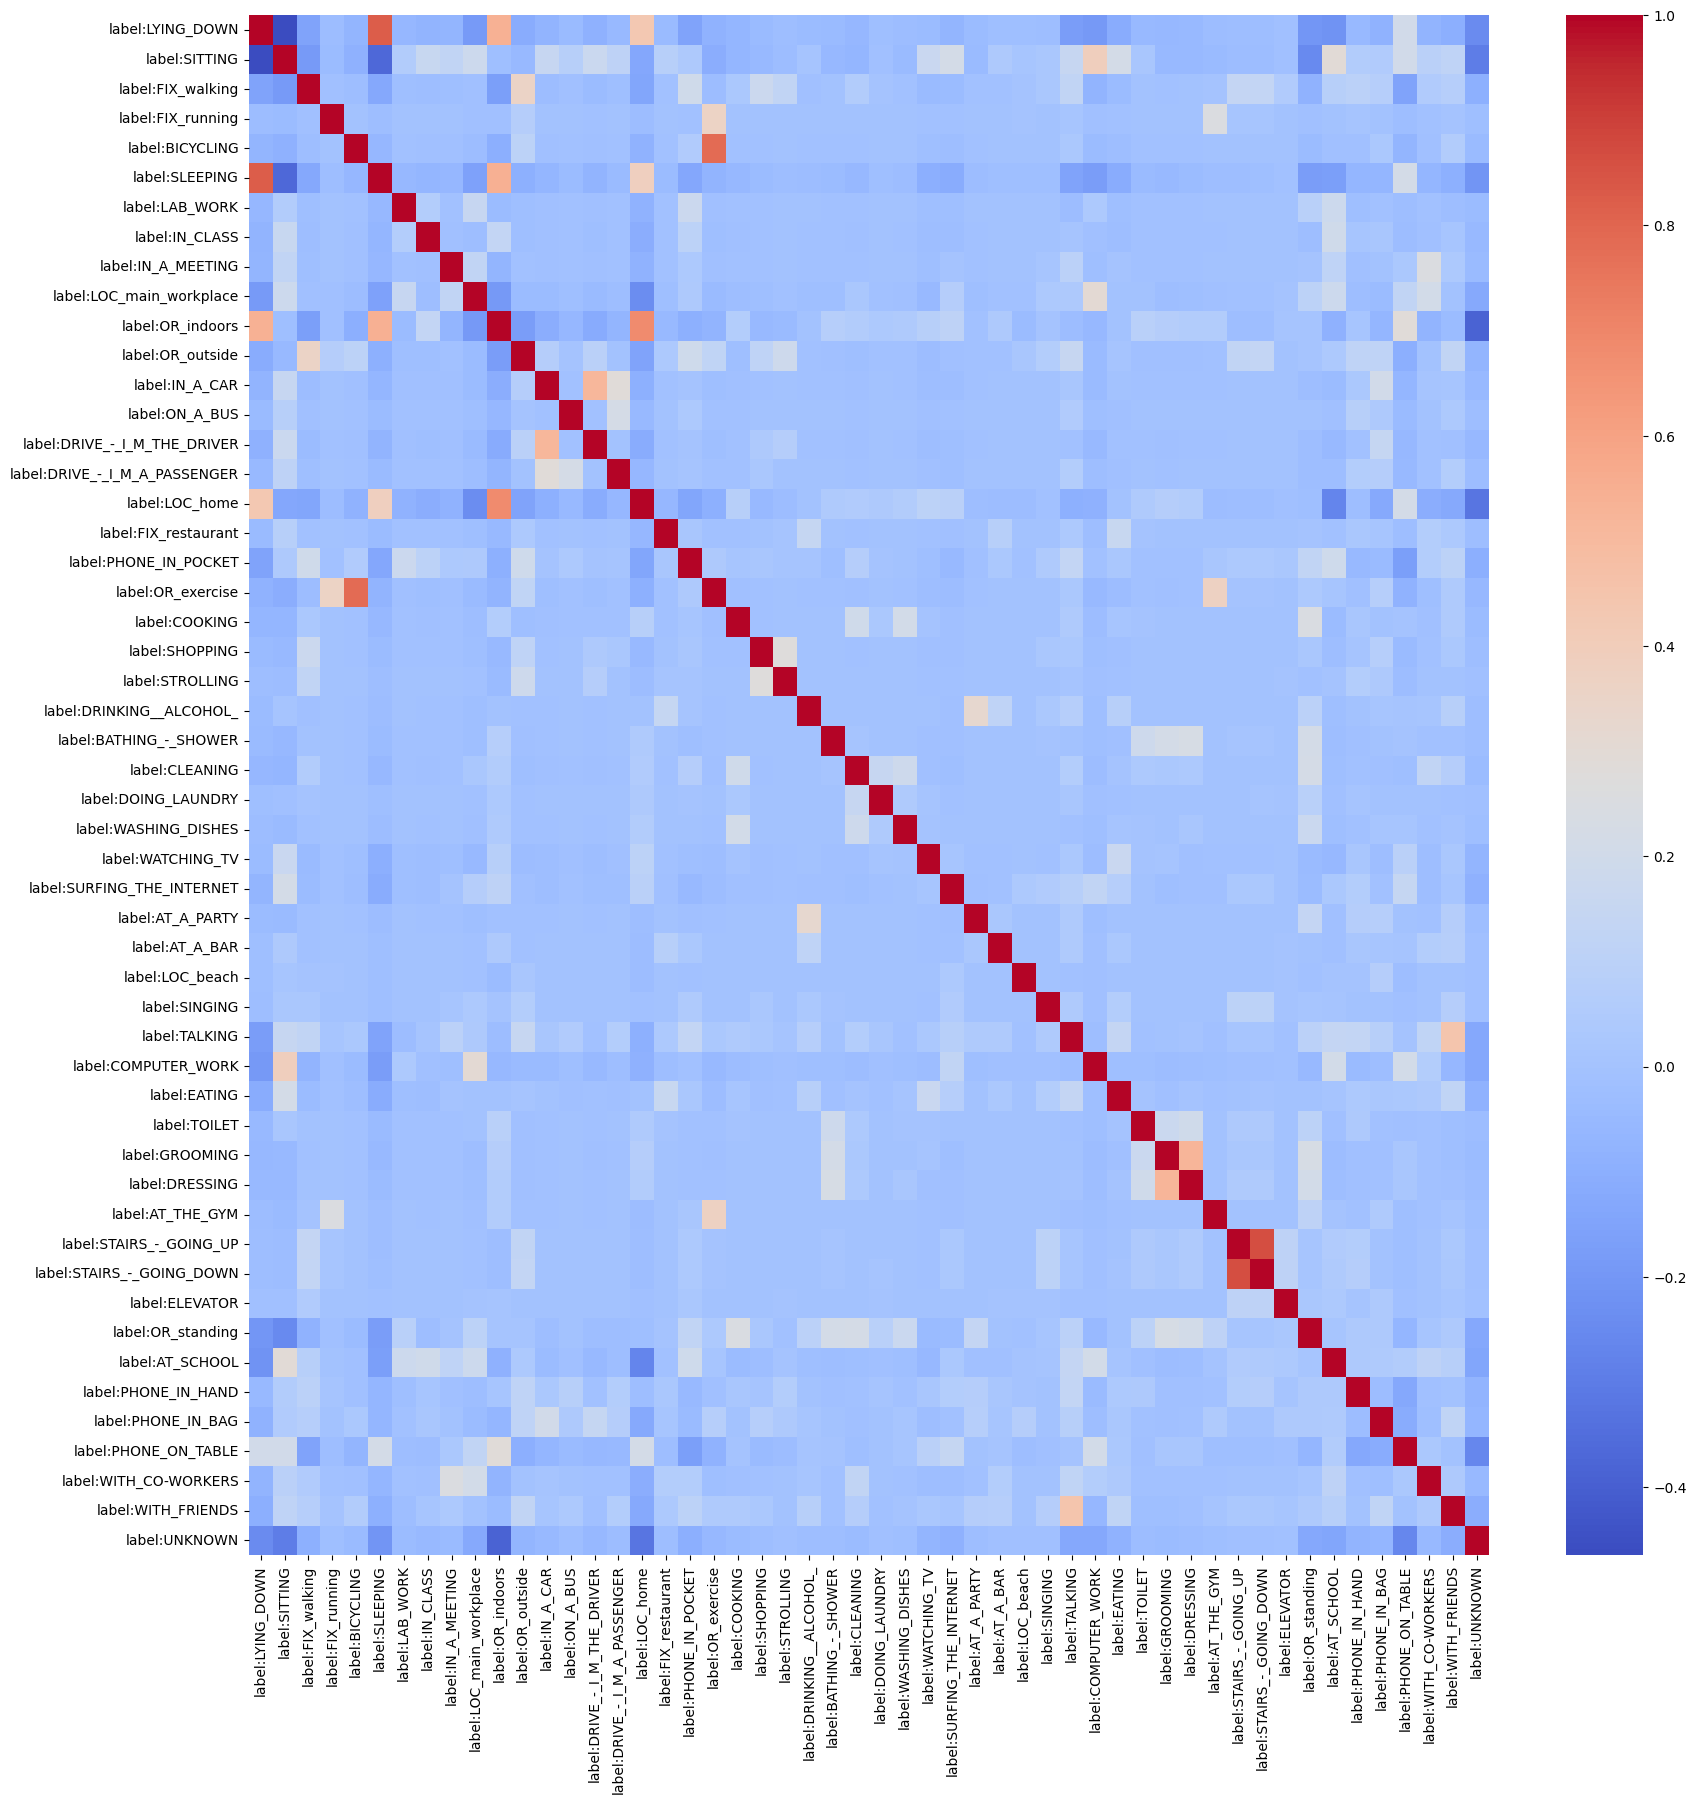

In [17]:
plt.figure(figsize = (20,20))
corr = y.corr(method = 'pearson')
corr_flat = corr.unstack().sort_values(ascending =False)

sns.heatmap(corr, annot = False, cmap = 'coolwarm')
plt.show()

In [18]:
# Initialize Classifier Chain with a RandomForest base classifier
classifier = ClassifierChain(RandomForestClassifier())

# Train the Classifier Chain model
classifier.fit(X_train, y_train)

# Make predictions
predictions = classifier.predict(X_test)

# Note: accuracy_score expects single-label predictions,
# so for multi-label you might use another metric like hamming loss or a subset accuracy function
# Here's an example with a custom subset accuracy for multi-label
def subset_accuracy(y_true, y_pred):
    return (y_true == y_pred).all(axis=1).mean()

print("Subset Accuracy: ", subset_accuracy(y_test, predictions.toarray()))

Subset Accuracy:  0.7812375778455015


In [19]:
user = users[0]

models_data = {
    'models': {},
    'accuracies': {}
}

### Testing to see if creating separate models is computationally expensive.

#### Individual Models

In [20]:
combined_csv_data_4_model = combined_csv_data.copy()
combined_csv_data_4_model['timestamp_numeric'] = combined_csv_data_4_model['timestamp'].astype(np.int64) // 10**9
combined_csv_data_4_model = combined_csv_data_4_model.drop(columns=['timestamp'])

warnings.simplefilter(action='ignore', category=RuntimeWarning)

counter = 1

for user in users:
    
    user_df = combined_csv_data_4_model[combined_csv_data['user_id'] == user]
    
    print(f'Shape of df of user no. {counter} of id {user} is: {user_df.shape}')
    # Assuming 'combined_csv_data' is your DataFrame
    X = user_df[features_to_include]
    y = user_df[output_columns]
    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Initialize Classifier Chain with a RandomForest base classifier
    classifier = ClassifierChain(RandomForestClassifier())
    # Train the Classifier Chain model
    classifier.fit(X_train, y_train)
    models_data['models'][user] = classifier
     # Make predictions
    predictions = classifier.predict(X_test)
    # Evaluate your model
    # Example: Using accuracy score, you can choose other metrics as appropriate

    # Note: accuracy_score expects single-label predictions,
    # so for multi-label you might use another metric like hamming loss or a subset accuracy function
    # Here's an example with a custom subset accuracy for multi-label
    def subset_accuracy(y_true, y_pred):
        return (y_true == y_pred).all(axis=1).mean()
    accuracy = subset_accuracy(y_test, predictions.toarray())
    models_data['accuracies'][user] = accuracy
    print(f"Subset Accuracy for {user}: ", accuracy)
    with open('clfs_2.pkl', 'wb') as file:
        pickle.dump(models_data, file)
    print('File Updated')
    counter = counter +1

Shape of df of user no. 1 of id 81536B0A-8DBF-4D8A-AC24-9543E2E4C8E0 is: (6407, 280)
Subset Accuracy for 81536B0A-8DBF-4D8A-AC24-9543E2E4C8E0:  0.9438377535101404
File Updated
Shape of df of user no. 2 of id 61359772-D8D8-480D-B623-7C636EAD0C81 is: (6079, 280)
Subset Accuracy for 61359772-D8D8-480D-B623-7C636EAD0C81:  0.9769736842105263
File Updated
Shape of df of user no. 3 of id 40E170A7-607B-4578-AF04-F021C3B0384A is: (7649, 280)
Subset Accuracy for 40E170A7-607B-4578-AF04-F021C3B0384A:  0.949673202614379
File Updated
Shape of df of user no. 4 of id 806289BC-AD52-4CC1-806C-0CDB14D65EB6 is: (9242, 280)
Subset Accuracy for 806289BC-AD52-4CC1-806C-0CDB14D65EB6:  0.9497025419145484
File Updated
Shape of df of user no. 5 of id 61976C24-1C50-4355-9C49-AAE44A7D09F6 is: (8730, 280)
Subset Accuracy for 61976C24-1C50-4355-9C49-AAE44A7D09F6:  0.9616265750286369
File Updated
Shape of df of user no. 6 of id D7D20E2E-FC78-405D-B346-DBD3FD8FC92B is: (6210, 280)
Subset Accuracy for D7D20E2E-FC78-40

#### General Model Test

In [35]:
print(f'Shape of df is: {combined_csv_data_4_model.shape}')
# Assuming 'combined_csv_data' is your DataFrame
X = combined_csv_data_4_model[features_to_include]
y = combined_csv_data_4_model[output_columns]
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize Classifier Chain with a RandomForest base classifier
classifier = ClassifierChain(RandomForestClassifier())
# Train the Classifier Chain model
classifier.fit(X_train, y_train)
models_data['models']["all"] = classifier
    # Make predictions
print('Processing predictions for X_test.')
predictions = classifier.predict(X_test)

def subset_accuracy(y_true, y_pred):
    return (y_true == y_pred).all(axis=1).mean()
print('Processing accuracy.')

accuracy = subset_accuracy(y_test, predictions.toarray())
models_data['accuracies']["all"] = accuracy
print(f"Subset Accuracy for all together data is: ", accuracy)
with open('all_clfs_2.pkl', 'wb') as file:
    pickle.dump(models_data, file)
print('File Updated')

Shape of df is: (377346, 280)
Processing predictions for X_test.
Processing accuracy.
Subset Accuracy for all together data is:  0.781171326354843
File Updated


For the IoT, we will use the general model and use the individual model once the accuracy or individual model passes the general model. Both of these iterations are to predict the current labels using sensor data. 

## Using classifier chains to generate predictions for LSTM
Let's use the success of our classifier chains for individual users to generate predictions for our LSTM model. First we'll prepare the predictions generated by the classifier chains.

In [22]:
# Preparing dataset for predictions
combined_csv_data_4_model = combined_csv_data.copy()
combined_csv_data_4_model['timestamp_numeric'] = pd.to_datetime(combined_csv_data_4_model['timestamp']).astype(np.int64) // 10**9
combined_csv_data_4_model = combined_csv_data_4_model.drop(columns=['timestamp'])

# Creating user_specific_data dictionary
user_specific_data = {}
for user in users:
    user_df = combined_csv_data_4_model[combined_csv_data_4_model['user_id'] == user]
    
    # Sorting user_df by 'timestamp_numeric' to ensure temporal order
    user_df = user_df.sort_values(by='timestamp_numeric')
    user_specific_data[user] = user_df

# Loading models from disk
with open('clfs_2.pkl', 'rb') as file:
    models_data = pickle.load(file)

# Defining function to generate predictions using classifier chains
def generate_classifier_chain_predictions(user_df, classifier_chain_model):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(user_df[features_to_include])

    # Generating predictions
    predictions = classifier_chain_model.predict(X_scaled)
    return predictions.toarray()

user_predictions = {}
for user_id, user_data in user_specific_data.items():
    user_df = user_specific_data[user_id]
    classifier_chain_model = models_data['models'][user_id]
    user_predictions[user_id] = generate_classifier_chain_predictions(user_df, classifier_chain_model)

# Now 'user_predictions' contains predictions for each user that can be used as input for the LSTM

In [23]:
# # Checking if all predictions are 2D arrays with a consistent second dimension
for user_id, predictions in user_predictions.items():
    print(f"User ID: {user_id}, Shape: {np.array(predictions).shape}")

consistent_shape = True
second_dim = None

for predictions in user_predictions.values():
    np_predictions = np.array(predictions)
    if second_dim is None:
        second_dim = np_predictions.shape[1] if len(np_predictions.shape) > 1 else 0
    elif len(np_predictions.shape) <= 1 or np_predictions.shape[1] != second_dim:
        consistent_shape = False
        break

if consistent_shape and second_dim:
    print(f"All predictions are 2D arrays with a consistent second dimension: {second_dim}")
else:
    print("Predictions are not consistent 2D arrays or have varying second dimensions.")

# Padding and stacking for LSTM input shpae
max_sequence_length = max([len(predictions) for predictions in user_predictions.values()])
X_lstm = pad_sequences(list(user_predictions.values()), maxlen=max_sequence_length, padding='post', dtype='float64')
original_lengths = [len(predictions) for predictions in user_predictions.values()]
X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 52))

print(f"LSTM input shape: {X_lstm.shape}")


User ID: 81536B0A-8DBF-4D8A-AC24-9543E2E4C8E0, Shape: (6407, 52)
User ID: 61359772-D8D8-480D-B623-7C636EAD0C81, Shape: (6079, 52)
User ID: 40E170A7-607B-4578-AF04-F021C3B0384A, Shape: (7649, 52)
User ID: 806289BC-AD52-4CC1-806C-0CDB14D65EB6, Shape: (9242, 52)
User ID: 61976C24-1C50-4355-9C49-AAE44A7D09F6, Shape: (8730, 52)
User ID: D7D20E2E-FC78-405D-B346-DBD3FD8FC92B, Shape: (6210, 52)
User ID: 7D9BB102-A612-4E2A-8E22-3159752F55D8, Shape: (1600, 52)
User ID: 5119D0F8-FCA8-4184-A4EB-19421A40DE0D, Shape: (6617, 52)
User ID: 9DC38D04-E82E-4F29-AB52-B476535226F2, Shape: (9686, 52)
User ID: A7599A50-24AE-46A6-8EA6-2576F1011D81, Shape: (3898, 52)
User ID: 59EEFAE0-DEB0-4FFF-9250-54D2A03D0CF2, Shape: (7542, 52)
User ID: 24E40C4C-A349-4F9F-93AB-01D00FB994AF, Shape: (4771, 52)
User ID: 9759096F-1119-4E19-A0AD-6F16989C7E1C, Shape: (9959, 52)
User ID: 1155FF54-63D3-4AB2-9863-8385D0BD0A13, Shape: (2685, 52)
User ID: 96A358A0-FFF2-4239-B93E-C7425B901B47, Shape: (5819, 52)
User ID: 78A91A4E-4A51-40

In [24]:
# Creating user specific timestamp dictionaries
user_specific_timestamps = {}
for user in users:
    user_df = combined_csv_data[combined_csv_data['user_id'] == user]
    user_df = user_df.sort_values(by='timestamp')
    user_specific_timestamps[user] = user_df['timestamp'].values

# Padding the timestamps to have the same length as the sequences
padded_timestamps = pad_sequences(list(user_specific_timestamps.values()), maxlen=max_sequence_length, padding='post', value=None, dtype='float64')  # Use "NONE" as a placeholder for non-real timestamps
original_timestamp_lengths = [len(ts) for ts in user_specific_timestamps.values()]

# Now 'padded_timestamps' contains the ordered timestamps for each user

Now let's prepare the LSTM model

In [25]:
# Initializing model
model = Sequential([
    LSTM(50, input_shape=(X_lstm.shape[1], X_lstm.shape[2]), return_sequences=True),
    Dropout(0.5),
    LSTM(50, return_sequences=False),
    Dropout(0.5),
    Dense(100, activation='relu'),
    Dense(len(label_columns), activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

# Extracting user labels
user_labels = {}
for user_id in users:
    user_labels_df = combined_csv_data[combined_csv_data['user_id'] == user_id]
    labels_array = user_labels_df[label_columns].values 
    user_labels[user_id] = labels_array

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 11996, 50)         20600     
                                                                 
 dropout (Dropout)           (None, 11996, 50)         0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 100)               5100      
                                                                 
 dense_1 (Dense)             (None, 52)                5252      
                                                                 
Total params: 51152 (199.81 KB)
Trainable params: 51152 

In [26]:
# Checking shape for padding
for user_id, labels in user_labels.items():
    print(f"User ID: {user_id}, Labels shape: {labels.shape}")

User ID: 81536B0A-8DBF-4D8A-AC24-9543E2E4C8E0, Labels shape: (6407, 52)
User ID: 61359772-D8D8-480D-B623-7C636EAD0C81, Labels shape: (6079, 52)
User ID: 40E170A7-607B-4578-AF04-F021C3B0384A, Labels shape: (7649, 52)
User ID: 806289BC-AD52-4CC1-806C-0CDB14D65EB6, Labels shape: (9242, 52)
User ID: 61976C24-1C50-4355-9C49-AAE44A7D09F6, Labels shape: (8730, 52)
User ID: D7D20E2E-FC78-405D-B346-DBD3FD8FC92B, Labels shape: (6210, 52)
User ID: 7D9BB102-A612-4E2A-8E22-3159752F55D8, Labels shape: (1600, 52)
User ID: 5119D0F8-FCA8-4184-A4EB-19421A40DE0D, Labels shape: (6617, 52)
User ID: 9DC38D04-E82E-4F29-AB52-B476535226F2, Labels shape: (9686, 52)
User ID: A7599A50-24AE-46A6-8EA6-2576F1011D81, Labels shape: (3898, 52)
User ID: 59EEFAE0-DEB0-4FFF-9250-54D2A03D0CF2, Labels shape: (7542, 52)
User ID: 24E40C4C-A349-4F9F-93AB-01D00FB994AF, Labels shape: (4771, 52)
User ID: 9759096F-1119-4E19-A0AD-6F16989C7E1C, Labels shape: (9959, 52)
User ID: 1155FF54-63D3-4AB2-9863-8385D0BD0A13, Labels shape: (26

In [27]:
# Padding labels
padded_labels = []

for user_id, labels in user_labels.items():
    # Padding the user's label array to have the same length as the max_sequence_length
    padded_label = pad_sequences([labels], maxlen=max_sequence_length, padding='post', dtype='float64')[0]
    padded_labels.append(padded_label)

y_lstm = np.array(padded_labels)

print(f"Padded labels shape: {y_lstm.shape}")

Padded labels shape: (60, 11996, 52)


In [28]:
# We'll reduce the dimensionality of y_lstm to just two dimensions: (number of samples, number of labels)
y_lstm = y_lstm[:, 0, :] 

print(f"Adjusted labels shape: {y_lstm.shape}")

Adjusted labels shape: (60, 52)


In [29]:
# Splitting data for training & validation
X_train, X_val, y_train, y_val = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

# Training model
history = model.fit(
    X_train, 
    y_train, 
    epochs=10, 
    batch_size=64, 
    validation_data=(X_val, y_val),
    verbose=1
)

# Evaluating model
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)

print(f'Validation accuracy: {val_acc}, Validation loss: {val_loss}')

Epoch 1/10


2024-02-25 23:27:55.039923: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


1/1 [==============================] - 4s 4s/step - loss: 0.6931 - accuracy: 0.0000e+00 - val_loss: 0.6921 - val_accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.6920 - accuracy: 0.0208 - val_loss: 0.6907 - val_accuracy: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.6906 - accuracy: 0.0417 - val_loss: 0.6890 - val_accuracy: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.6888 - accuracy: 0.0833 - val_loss: 0.6868 - val_accuracy: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.6863 - accuracy: 0.1042 - val_loss: 0.6841 - val_accuracy: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.6837 - accuracy: 0.1250 - val_loss: 0.6805 - val_accuracy: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.6794 - accuracy: 0.1250 - val_loss: 0.6758 - val_accuracy: 0.0000e+00
Epoch 8/10
1/1 [====

In [30]:
# Generating predictions for the validation set
predictions = model.predict(X_val)

# Applying threshold to convert propabilities to binary values
binary_predictions = (predictions > 0.5).astype(int)

# Lets examine a few predictions to get a sense of what our model is doing 
for i, prediction in enumerate(binary_predictions[:5]):
    print(f"Prediction for sample {i}: {prediction}")

# Lets map these to the label names so we know what the predictions mean 
for i, prediction in enumerate(binary_predictions[:5]):
    labeled_prediction = dict(zip(label_columns, prediction))
    print(f"Prediction for sample {i}: {labeled_prediction}")

# Load all predictions into a dataframe
predictions_df = pd.DataFrame(binary_predictions, columns=label_columns)
predictions_df.to_csv('LSTM_model_predictions_with_labels.csv', index=False)

1/1 [==============================] - 1s 678ms/step
Prediction for sample 0: [0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0]
Prediction for sample 1: [0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0]
Prediction for sample 2: [0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0]
Prediction for sample 3: [0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0]
Prediction for sample 4: [0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0]
Prediction for sample 0: {'label:LYING_DOWN': 0, 'label:SITTING': 1, 'label:FIX_walking': 0, 'label:FIX_running': 0, 'label:BICYCLING': 0, 'label:SLEEPING': 0, 'label:LAB_WORK': 0, 'label:IN_CLASS': 0, 'label:IN_A_MEETING': 0, 'label:LOC_main_workplace': 0, 'label:OR_indoors': 1, 'label

## Adding linear model for input predictions
Let's see if we can leverage the predicted labels from our LSTM model to use a linear model for input predictions. 

In [31]:
# Initializing model
X = y_lstm 
y = X_lstm.reshape(X_lstm.shape[0], -1) 

# Splitting the dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Making predictions - predicting features based on labels
y_pred = linear_model.predict(X_test)

# Evaluating model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Saving predictions to csv
predictions_df = pd.DataFrame(y_pred, columns=[f'Feature_{i}' for i in range(y_pred.shape[1])])
predictions_df.to_csv('predicted_features.csv', index=False)
print("Predictions saved to 'predicted_features.csv'.")

Mean Squared Error: 0.041695330956177674
Predictions saved to 'predicted_features.csv'.


Old numbers
Shape of df is: (377346, 280)
Processing predictions for X_test.
Processing accuracy.
Subset Accuracy for all together data is:  0.40275606201139524
File Updated

# Experimentations

This part of the notebook documents the experimentation with different model architectures, hyperparameters, and data imputation methods to optimize performance. It includes testing various approaches to handle missing values, experimenting with batch sizes, and evaluating the impact of different thresholds for missing data on model accuracy.

In [32]:
# Define your MLP model
class MultiTaskMLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(MultiTaskMLP, self).__init__()
        self.layer1 = nn.Linear(input_size, 64)
        self.layer2 = nn.Linear(64, 64)
        self.output_layer = nn.Linear(64, output_size)
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.output_layer(x)
        return x

# Placeholder for models and accuracies
models_data_2 = {
    'models': {},
    'accuracies': {}
}

# Loop through each user
for user in users:
    user_df = combined_csv_data_4_model[combined_csv_data_4_model['user_id'] == user]
    X = user_df[features_to_include].values
    y = user_df[output_columns].values
    
    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.FloatTensor(y_test)
    
    # DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    # Initialize the model
    model = MultiTaskMLP(input_size=X_train_tensor.shape[1], output_size=y_train_tensor.shape[1])
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    for epoch in range(10):  # Adjust epochs as needed
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
    # Evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = torch.sigmoid(outputs) > 0.5  # Threshold at 0.5
            total += labels.size(0)
            correct += (predicted == labels).float().mean()
    accuracy = correct / total
    
    # Store the model and accuracy
    models_data_2['models'][user] = model.state_dict()  # Store state dict for minimal size
    models_data_2['accuracies'][user] = accuracy.item()
    print(f"User {user}: Accuracy = {accuracy.item():.4f}")

# Save the models and accuracies
with open('mlp_models.pkl', 'wb') as file:
    pickle.dump(models_data_2, file)


User 81536B0A-8DBF-4D8A-AC24-9543E2E4C8E0: Accuracy = 0.0161
User 61359772-D8D8-480D-B623-7C636EAD0C81: Accuracy = 0.0152
User 40E170A7-607B-4578-AF04-F021C3B0384A: Accuracy = 0.0153
User 806289BC-AD52-4CC1-806C-0CDB14D65EB6: Accuracy = 0.0151
User 61976C24-1C50-4355-9C49-AAE44A7D09F6: Accuracy = 0.0155
User D7D20E2E-FC78-405D-B346-DBD3FD8FC92B: Accuracy = 0.0156
User 7D9BB102-A612-4E2A-8E22-3159752F55D8: Accuracy = 0.0149
User 5119D0F8-FCA8-4184-A4EB-19421A40DE0D: Accuracy = 0.0153
User 9DC38D04-E82E-4F29-AB52-B476535226F2: Accuracy = 0.0153
User A7599A50-24AE-46A6-8EA6-2576F1011D81: Accuracy = 0.0161
User 59EEFAE0-DEB0-4FFF-9250-54D2A03D0CF2: Accuracy = 0.0154
User 24E40C4C-A349-4F9F-93AB-01D00FB994AF: Accuracy = 0.0151
User 9759096F-1119-4E19-A0AD-6F16989C7E1C: Accuracy = 0.0157
User 1155FF54-63D3-4AB2-9863-8385D0BD0A13: Accuracy = 0.0162
User 96A358A0-FFF2-4239-B93E-C7425B901B47: Accuracy = 0.0160
User 78A91A4E-4A51-4065-BDA7-94755F0BB3BB: Accuracy = 0.0156
User F50235E0-DD67-4F2A-

In [33]:
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(combined_csv_data_4_model[features_to_include])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, combined_csv_data_4_model[output_columns], test_size=0.2, random_state=42)


# Convert dataset to tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train.values)  # For multi-label
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test.values)  # For multi-label


# DataLoader setup
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model setup
model = nn.Sequential(
    nn.Linear(len(features_to_include), 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Linear(64, len(output_columns))
)

# Loss and optimizer setup
criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
model.train()
for epoch in range(10):  # Number of epochs
    for inputs, labels in train_loader:
        lr = 0.0001 * (epoch + 1)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/10, Loss: {loss.item():.4f}')

# Testing loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = torch.sigmoid(outputs) > 0.5  # Applying sigmoid and threshold for multi-label
        total += labels.size(0)
        correct += (predicted == labels.byte()).all(dim=1).sum().item()  # Adjust for multi-label accuracy
accuracy = 100 * correct / total

print(f'Accuracy: {accuracy:.2f}%')


Epoch 1/10, Loss: 0.1633
Epoch 2/10, Loss: 0.1635
Epoch 3/10, Loss: 0.1356
Epoch 4/10, Loss: 0.1631
Epoch 5/10, Loss: 0.1300
Epoch 6/10, Loss: 0.1731
Epoch 7/10, Loss: 0.1428
Epoch 8/10, Loss: 0.1365
Epoch 9/10, Loss: 0.1323
Epoch 10/10, Loss: 0.1796
Accuracy: 7.71%


In [34]:


numeric_cols = user_df.select_dtypes(include=[np.number]).columns.tolist()

# Update features_to_include to contain only numeric columns
features_to_include = [col for col in features_to_include if col in numeric_cols]

# Apply scaling on numeric columns only
s1 = MinMaxScaler(feature_range=(-1,1))
user_df_scaled = s1.fit_transform(user_df[features_to_include])
user_df_scaled = pd.DataFrame(user_df_scaled, columns=features_to_include)

# Create sequences
look_back = 4
generator = TimeseriesGenerator(user_df_scaled.values, user_df_scaled.values,
                                length=look_back, batch_size=1)
def create_lstm_model(input_shape, num_features):
    model = Sequential([
        LSTM(units = num_features, activation='relu', input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        Dense(num_features),
        LSTM(units=num_features, return_sequences=True),
        Dropout(0.2),        
        LSTM(units=num_features, return_sequences=True),
        Dense(num_features),
        Dropout(0.2),
        LSTM(units=num_features, return_sequences=True),
        Dense(num_features),
        Dropout(0.2),        
        LSTM(units=num_features),
        Dense(num_features),
        Activation('linear'),
        
    ])
    model.compile(optimizer='adam', loss='mse', metrics = ['accuracy'])  
    return model
model_path = 'LSTM_next_model.h5'
# Define and compile the LSTM model
model = create_lstm_model((look_back, len(features_to_include)), len(features_to_include))


if os.path.exists(model_path):
    load_model(model_path)
else:

    model.fit(generator, epochs=1) 
    model.save(model_path)

In [55]:
def predict_from_df(df, model, features_to_include, look_back=4):
    df_filtered = df[features_to_include]
    
    if len(df_filtered) >= look_back:
        # Extract the last `look_back` rows for the prediction
        last_sequences = df_filtered[-look_back:].values.reshape((1, look_back, len(features_to_include)))
    else:
        raise ValueError(f"DataFrame must have at least {look_back} rows for prediction.")
    
    # Predict the next row using the LSTM model
    predictions = model.predict(last_sequences)
    
    
    return predictions

def compare_predictions_with_actual(df, model, features_to_include, look_back=3):
    predictions = predict_from_df(user_df.iloc[1:5], model, features_to_include, look_back)
    predictions = s1.inverse_transform(predictions)
    actual_values = user_df.iloc[4][features_to_include].values  # Adjust index if needed
    
    return predictions, actual_values

# Assuming 'user_df' is already preprocessed appropriately, including scaling
predictions, actual_values = compare_predictions_with_actual(user_df, model, features_to_include, look_back=4)

# Now you can compare 'predictions' with 'actual_values'
# Note: If your data was scaled, you might need to inverse scale both predictions and actual values before comparison

print(f"{'Predictions':<15}   | {'Actual Values':<15} | {'Diff':<15} | {'Diff %':<15}")
print("-" * 47)  # Adjust the number based on the width of your columns

actual_values_0 = actual_values.reshape(-1, 1) if actual_values.ndim == 1 else actual_values
predictions_0 = predictions[0].reshape(-1, 1) if predictions[0].ndim == 1 else predictions[0]


def subset_accuracy(y_true, y_pred):
    return (y_true == y_pred).all(axis=1).mean()

print("Subset Accuracy: ", subset_accuracy(actual_values, predictions_0))
j = 0
for i in range(len(predictions[j])):
    p = predictions[j][i]
    
    a = actual_values[i]
    diff = a-p
    diff_p = ((p-a)/a)*100
    print(f"{p:.6f}{'':<9} | {a:<15} | {diff:.6f} | {diff_p:.6f}")



1/1 [==============================] - 0s 68ms/step
Predictions       | Actual Values   | Diff            | Diff %         
-----------------------------------------------
Subset Accuracy:  0.0
0.504454          | 0.0             | -0.504454 | inf
0.501700          | 0.0             | -0.501700 | inf
0.496406          | 0.0             | -0.496406 | inf
0.495522          | 1.0             | 0.504478 | -50.447839
0.500878          | 1.0             | 0.499122 | -49.912161
0.492371          | 0.0             | -0.492371 | inf
0.494324          | 0.0             | -0.494324 | inf
0.505359          | 0.0             | -0.505359 | inf
0.501257          | 0.0             | -0.501257 | inf
0.504051          | 0.0             | -0.504051 | inf
0.501859          | 0.0             | -0.501859 | inf
0.500735          | 0.0             | -0.500735 | inf
0.489402          | 1.0             | 0.510598 | -51.059756
0.504047          | 0.0             | -0.504047 | inf
0.495487          | 0.0         

In [58]:
predictions_0[predictions_0 < 0.5] = 0
predictions_0[predictions_0 >= 0.5] = 1
print("Subset Accuracy: ", subset_accuracy(actual_values, predictions_0))

Subset Accuracy:  0.0


## Testing CNN And LSTM for prediction

In [39]:

# Adjust the input shape according to your dataset
input_shape = (X_train.shape[1], 1)  # Assuming non-sequential data for simplicity

model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    # Instead of Flatten, use Reshape or adjust the model so it's suitable for LSTM input
    # Reshape example (adjust the target shape according to your needs):
    # This line is illustrative; actual reshaping depends on the output shape of the previous layer
    Reshape((-1, 128)),  # Adjust the target shape
    LSTM(50, return_sequences=False),  # If you want the LSTM to output a sequence, set return_sequences=True
    Dropout(0.5),
    Dense(100, activation='relu'),
    Dense(len(label_columns), activation='sigmoid')  # Use 'sigmoid' for multi-label classification
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',  # Use 'binary_crossentropy' for multi-label classification
              metrics=['accuracy'])

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 33, 64)            256       
                                                                 
 max_pooling1d (MaxPooling1  (None, 16, 64)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 14, 128)           24704     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 7, 128)            0         
 g1D)                                                            
                                                                 
 reshape (Reshape)           (None, 7, 128)            0         
                                                                 
 lstm_12 (LSTM)              (None, 50)               

In [30]:
# Reshape data for CNN if needed
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [74]:
X_test_padded = np.pad(X_test, ((0, 0), (0, 159 - 35)), 'constant', constant_values=0)
X_test_reshaped = X_test_padded.reshape(-1, 159, 1)

print(X_test_reshaped.shape) 

(75470, 159, 1)


In [75]:
# Testing Shape Issues
model_name = 'first_try.h5'
if os.path.exists(model_name):
    model = load_model(model_name)
else:
    history = model.fit(X_train_reshaped, y_train,
                    epochs=1,  
                    batch_size=64, 
                    validation_split=0.2, 
                    verbose=1)  

    model.save(model_name)


test_loss, test_acc = model.evaluate(X_test_reshaped, y_test, verbose=2)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

2359/2359 - 13s - loss: 0.6903 - accuracy: 0.2765 - 13s/epoch - 5ms/step
Test accuracy: 0.2765204608440399, Test loss: 0.6902987360954285


In [78]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * math.exp(-0.1)

callback = LearningRateScheduler(scheduler)

# Define the input shape based on your data's features
input_shape = (35, 1)  # Adjust this based on your dataset's feature count

model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Reshape((-1, 128)),  # Adjust based on the output shape of the previous layer
    Bidirectional(LSTM(100, return_sequences=False)),
    Dropout(0.5),
    Dense(100, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dense(len(label_columns), activation='sigmoid')  # Adjust based on your label columns
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

model_name = 'second_try.h5'
if os.path.exists(model_name):
    model = load_model(model_name)
else:
    model.fit(X_train, y_train, epochs=1,batch_size=128,  validation_split=0.2)
    model.save(model_name)

test_loss, test_acc = model.evaluate(X_test_reshaped, y_test, verbose=2)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 33, 64)            256       
                                                                 
 batch_normalization (Batch  (None, 33, 64)            256       
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 16, 64)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 14, 128)           24704     
                                                                 
 batch_normalization_1 (Bat  (None, 14, 128)           512       
 chNormalization)                                                
                                                      

2359/2359 - 46s - loss: nan - accuracy: 0.0472 - 46s/epoch - 20ms/step
Test accuracy: 0.04721081256866455, Test loss: nan


In [79]:
callback = LearningRateScheduler(scheduler)

model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Reshape((-1, 128)),  # Adjust based on the output shape of the previous layer
    Bidirectional(LSTM(100, return_sequences=False)),
    Dropout(0.5),
    Dense(100, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dense(len(label_columns), activation='sigmoid')  # Adjust based on your label columns
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 33, 64)            256       
                                                                 
 batch_normalization_3 (Bat  (None, 33, 64)            256       
 chNormalization)                                                
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 16, 64)            0         
 g1D)                                                            
                                                                 
 reshape_1 (Reshape)         (None, 8, 128)            0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 200)               183200    
 onal)                                                           
                                                      

In [80]:
model_name = 'third_try.h5'
if os.path.exists(model_name):
    model = load_model(model_name)
else:
    model.fit(X_train, y_train, epochs=1,batch_size=128,  validation_split=0.2)
    model.save(model_name)
    # Evaluate the model
    test_loss, test_acc = model.evaluate(X_test_reshaped, y_test, verbose=2)
    print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

test_loss, test_acc = model.evaluate(X_test_reshaped, y_test, verbose=2)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')


2359/2359 - 36s - loss: nan - accuracy: 0.0472 - 36s/epoch - 15ms/step
Test accuracy: 0.04721081256866455, Test loss: nan


In [89]:
model_name = 'third_try_2.h5'
if os.path.exists(model_name):
    model = load_model(model_name)
else:
    model.fit(X_train, y_train, epochs=1,batch_size=20,  validation_split=0.2)
    model.save(model_name)
    # Evaluate the model
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test, verbose=2)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')


2359/2359 - 36s - loss: nan - accuracy: 0.0472 - 36s/epoch - 15ms/step
Test accuracy: 0.04721081256866455, Test loss: nan


In [ ]:
model = Sequential([
    # Start with Conv1D layers to extract features from the sequence
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),

    # Use LSTM layer to process the features extracted by Conv1D layers
    LSTM(50, return_sequences=False),
    Dropout(0.2),

    # Dense layers for classification
    Dense(100, activation='relu'),
    Dense(len(label_columns), activation='sigmoid')  # Adjust based on your label columns
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',  # Adjust loss function based on your specific task
              metrics=['accuracy'])

model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 33, 64)            256       
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 16, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, 14, 128)           24704     
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 7, 128)            0         
 g1D)                                                            
                                                                 
 lstm_11 (LSTM)              (None, 50)                35800     
                                                                 
 dropout_10 (Dropout)        (None, 50)               

In [90]:
model_name = 'fourth_try_2.h5'
if os.path.exists(model_name):
    model = load_model(model_name)
else:
    model.fit(X_train, y_train, epochs=1, validation_split=0.2)
    model.save(model_name)

test_loss, test_acc = model.evaluate(X_test_reshaped, y_test, verbose=2)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

2359/2359 - 24s - loss: 0.1683 - accuracy: 0.0472 - 24s/epoch - 10ms/step
Test accuracy: 0.04721081256866455, Test loss: 0.16831281781196594


In [91]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Adjust the input shape according to your dataset
# For LSTM, input should be in the form of (samples, timesteps, features)
# Assuming each sample is a sequence of vectors
input_shape = (X_train.shape[1], 1)  # Adjust '1' if your data is already in sequences

model = Sequential()
# Start with an LSTM layer to process sequences
model.add(LSTM(units=64, return_sequences=True, input_shape=input_shape))
model.add(Dropout(0.2))

# Followed by CNN layers for feature extraction from sequences processed by LSTM
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Flatten the output to feed into a dense layer
model.add(Flatten())
# Additional dense layers or LSTM layers can be added here if needed
# Example: model.add(LSTM(50, return_sequences=False))

model.add(Dense(100, activation='relu'))
model.add(Dense(y_train.shape[1], activation='sigmoid'))  # Assuming 'y' is one-hot encoded for multi-label classification

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',  # Adjust the loss function as per your problem
              metrics=['accuracy'])

model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 35, 64)            16896     
                                                                 
 dropout_11 (Dropout)        (None, 35, 64)            0         
                                                                 
 conv1d_8 (Conv1D)           (None, 34, 64)            8256      
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 17, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_9 (Conv1D)           (None, 15, 128)           24704     
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, 7, 128)            0         
 g1D)                                                 

In [92]:
model_name = 'fifth_try_3.h5'
if os.path.exists(model_name):
    model = load_model(model_name)
else:
    model.fit(X_train, y_train, epochs=1, validation_split=0.2)
    model.save(model_name)

test_loss, test_acc = model.evaluate(X_test_reshaped, y_test, verbose=2)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

2359/2359 - 20s - loss: 0.1687 - accuracy: 0.0472 - 20s/epoch - 9ms/step
Test accuracy: 0.04721081256866455, Test loss: 0.1687190681695938


In [25]:
# Data Preprocessing
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)  # Normalize features

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Model Definition
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    Conv1D(64, kernel_size=2, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(y_train.shape[1], activation='sigmoid')  # Output layer
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])  # Add other metrics as needed

# Custom Callback for Precision, Recall, F1 Score
class MetricsCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_predict = (np.asarray(self.model.predict(X_test))).round()
        val_targ = y_test
        _val_precision = precision_score(val_targ, val_predict, average='micro')
        _val_recall = recall_score(val_targ, val_predict, average='micro')
        _val_f1 = f1_score(val_targ, val_predict, average='micro')
        print(f' — val_precision: {_val_precision:.4f} — val_recall: {_val_recall:.4f} — val_f1: {_val_f1:.4f}')

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 35, 64)            16896     
                                                                 
 dropout (Dropout)           (None, 35, 64)            0         
                                                                 
 conv1d (Conv1D)             (None, 34, 64)            8256      
                                                                 
 max_pooling1d (MaxPooling1  (None, 17, 64)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 128)           24704     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 7, 128)            0         
 g1D)                                                   

In [28]:
model_name = 'fifth_try_4.h5'
if os.path.exists(model_name):
    model = load_model(model_name)
else:
    model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          epochs=1, 
          batch_size=32,  
          callbacks=[MetricsCallback()])
    model.save(model_name)

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

2359/2359 - 12s - loss: 232.8806 - accuracy: 0.3565 - 12s/epoch - 5ms/step
Test accuracy: 0.3564992845058441, Test loss: 232.880615234375


## Testing Batch Sizes

In [19]:
def find_best_batch_size( X_train, y_train, X_test, y_test, batch_sizes):
    models_dict = {}
    best_acc = 0
    best_batch_size = None

    for batch_size in batch_sizes:
        print(f"Training with batch size: {batch_size}")
        
        model_file_name = f'ExtraSensory_CNN_LSTM_bs{batch_size}.h5'
        input_shape = (X_train.shape[1], 1) 
        # Clone the original model architecture for a fair comparison
        model_clone = Sequential([
                Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.001)),
                BatchNormalization(),
                MaxPooling1D(pool_size=2),
                Reshape((-1, 128)),  # Adjust based on the output shape of the previous layer
                Bidirectional(LSTM(100, return_sequences=False)),
                Dropout(0.5),
                Dense(100, activation='relu', kernel_regularizer=l2(0.001)),
                BatchNormalization(),
                Dense(len(label_columns), activation='sigmoid')  # Adjust based on your label columns
            ])
        
        # Recompile the model with the new optimizer instance
        model_clone.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
        
        if os.path.exists(model_file_name):
            model_clone = load_model(model_file_name)
        else:
            model_clone.fit(X_train, y_train, epochs=1, batch_size=batch_size, validation_split=0.2, verbose=1)
            model_clone.save(model_file_name)

        # Evaluate the model
        test_loss, test_acc = model_clone.evaluate(X_test, y_test, verbose=2)
        print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")
        
        # Save the model
        
       
        models_dict[batch_size] = model_file_name
        
        # Update the best model if the current is better
        if test_acc > best_acc:
            best_acc = test_acc
            best_batch_size = batch_size

    print(f"Best Batch Size: {best_batch_size} with Test Accuracy: {best_acc}")
    return best_batch_size, best_acc, models_dict



In [19]:
batch_sizes = [None, 4, 16, 64, 256, 512, 1024]
# Call the function and store its return values
best_batch_size, best_acc, models_dict = find_best_batch_size(X_train, y_train, X_test, y_test, batch_sizes)


Training with batch size: None


2359/2359 - 32s - loss: 0.1425 - accuracy: 0.3699 - 32s/epoch - 14ms/step
Test accuracy: 0.3698953092098236, Test loss: 0.14247830212116241
Training with batch size: 4


2024-02-26 05:38:06.559697: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


60375/60375 [==============================] - 1824s 30ms/step - loss: 0.1523 - accuracy: 0.3071 - val_loss: 0.1465 - val_accuracy: 0.2882
2359/2359 - 33s - loss: 0.1470 - accuracy: 0.2886 - 33s/epoch - 14ms/step
Test accuracy: 0.2886444926261902, Test loss: 0.14704400300979614
Training with batch size: 16


: 

In [20]:
# The kernal crashed, so resuming from whats left
batch_sizes = [16, 64, 256, 512, 1024]
# Call the function and store its return values
best_batch_size, best_acc, models_dict = find_best_batch_size(X_train, y_train, X_test, y_test, batch_sizes)

# Now `models_dict` is available outside of the function
print("Available models and their batch sizes:")
for batch_size, model_path in models_dict.items():
    print(f"Batch Size: {batch_size}, Model Path: {model_path}")

Training with batch size: 16


2024-02-26 06:16:01.596694: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


15094/15094 [==============================] - 540s 36ms/step - loss: 0.1525 - accuracy: 0.3492 - val_loss: 0.1421 - val_accuracy: 0.3107
2359/2359 - 31s - loss: 0.1427 - accuracy: 0.3143 - 31s/epoch - 13ms/step
Test accuracy: 0.3142838180065155, Test loss: 0.1426621526479721
Training with batch size: 64


2359/2359 - 31s - loss: 0.1419 - accuracy: 0.4151 - 31s/epoch - 13ms/step


Test accuracy: 0.4151450991630554, Test loss: 0.14189724624156952
Training with batch size: 256


2024-02-26 06:29:30.803758: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


944/944 [==============================] - 68s 69ms/step - loss: 0.2114 - accuracy: 0.3592 - val_loss: 0.1451 - val_accuracy: 0.3553
2359/2359 - 32s - loss: 0.1456 - accuracy: 0.3603 - 32s/epoch - 14ms/step


Test accuracy: 0.36027559638023376, Test loss: 0.14561079442501068
Training with batch size: 512


2024-02-26 06:33:58.684920: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


472/472 [==============================] - 55s 112ms/step - loss: 0.2706 - accuracy: 0.3607 - val_loss: 0.1472 - val_accuracy: 0.3751
2359/2359 - 35s - loss: 0.1477 - accuracy: 0.3817 - 35s/epoch - 15ms/step


Test accuracy: 0.381661593914032, Test loss: 0.14766614139080048
Training with batch size: 1024


2024-02-26 06:38:16.445456: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


236/236 [==============================] - 46s 185ms/step - loss: 0.3885 - accuracy: 0.3452 - val_loss: 0.1720 - val_accuracy: 0.0499
2359/2359 - 36s - loss: 0.1724 - accuracy: 0.0498 - 36s/epoch - 15ms/step
Test accuracy: 0.04975486919283867, Test loss: 0.1723817139863968
Best Batch Size: 64 with Test Accuracy: 0.4151450991630554
Available models and their batch sizes:
Batch Size: 16, Model Path: ExtraSensory_CNN_LSTM_bs16.h5
Batch Size: 64, Model Path: ExtraSensory_CNN_LSTM_bs64.h5
Batch Size: 256, Model Path: ExtraSensory_CNN_LSTM_bs256.h5
Batch Size: 512, Model Path: ExtraSensory_CNN_LSTM_bs512.h5
Batch Size: 1024, Model Path: ExtraSensory_CNN_LSTM_bs1024.h5


Best accuracy is with batchsize 64 of 0.4151.

## Testing Thresholds

In [33]:

# Calculate the total NaN count for each feature across all users
total_nan_counts = nan_counts_per_user.sum()

# Assuming `X_with_users` is your original DataFrame and has the same number of entries for each user,
# Calculate the total number of entries for a single feature across all users
total_entries_per_feature = len(X_with_users)  # Or, more specifically, len(users) * average_entries_per_user if varies

# Calculate the percentage of missing data for each feature
percentage_missing = (total_nan_counts / total_entries_per_feature) * 100


def testing_threshold(threshold, testing_user, fill_type= 'ffill', epochs = 1 ):

    # Decide on a threshold for removing columns, e.g., 1%
    threshold = threshold

    # Identify columns that exceed this threshold
    columns_to_remove = percentage_missing[percentage_missing > threshold].index.tolist()

    print("Removing ", len(columns_to_remove),"columns out of ", len(X_with_users.columns))
    # Print out the columns to remove
    # print("Columns to remove due to excessive missing data:", columns_to_remove)



    # First User 
    user_df = X_with_users[X_with_users['user_id'] == users[testing_user]]
    user_df.sort_values('timestamp', inplace=True)

    features_to_include = [feature for feature in features if feature not in columns_to_remove and feature != 'timestamp']


    if fill_type == 'ffill':
    # Forward fill
        user_df = user_df[features_to_include].ffill()
    elif fill_type == 'mean':
        # Fill missing values with the mean of each column
        mean_values = user_df[features_to_include].mean()
        user_df = user_df[features_to_include].fillna(mean_values)
    elif fill_type == 'median':
        # Fill missing values with the median of each column
        median_values = user_df[features_to_include].median()
        user_df = user_df[features_to_include].fillna(median_values)
    elif fill_type == 'zero':
        # Fill missing values with zero
        user_df = user_df[features_to_include].fillna(0)
    else:
        # If no valid fill_type is provided, print a warning or fill with a default method
        print("Invalid fill_type. No changes made to user_df.")



    numerical_features = user_df[features_to_include].select_dtypes(include=[np.number])

    scaler = StandardScaler()
    user_df[numerical_features.columns] = scaler.fit_transform(numerical_features)

    # Define LSTM model architecture
    def create_lstm_model(input_shape):
        model = Sequential([
            LSTM(50, activation='relu', input_shape=input_shape),
            Dense(len(features_to_include), activation='relu') 
        ])
        model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001, clipvalue=0.5), loss='mse')
    
        return model




    # Convert user_df to sequences for LSTM
    look_back = 3 
    generator = TimeseriesGenerator(user_df[features_to_include].values, user_df[features_to_include].values,
                                    length=look_back, batch_size=64)

    # Create and train LSTM model on the selected user's data
    model = create_lstm_model((look_back, len(features_to_include)))
    model.fit(generator, epochs=epochs, verbose=1)  # Adjust epochs and verbosity as needed

    return model, features_to_include


threshold_testing_models = {}
models_with_threshhold = {}
features_to_include = {}

for i in [0,1,2,3,4,5,10,15,20,25,30,40,50]:
    print("for threshold: ", i)
    models_with_threshhold[i], features_to_include[i] = testing_threshold(i, -1)


fill_options = ['mean', 'median', 'zero']
for fill in fill_options:
    print("Checking different fills at 5 threshhold with ", fill, ' fill option')
    models_with_threshhold[fill], features_to_include[fill] = testing_threshold(5, -1, fill_type = fill)



# The best one came out to be threshold = 0 fill =median with epoch of 1

for threshold:  0
Removing  192 columns out of  280


77/77 [==============================] - 3s 25ms/step - loss: 0.7552
for threshold:  1
Removing  165 columns out of  280


77/77 [==============================] - 2s 24ms/step - loss: 0.9103
for threshold:  2
Removing  163 columns out of  280


77/77 [==============================] - 2s 23ms/step - loss: 0.8679
for threshold:  3
Removing  137 columns out of  280


77/77 [==============================] - 2s 25ms/step - loss: 0.9397
for threshold:  4
Removing  137 columns out of  280


77/77 [==============================] - 3s 26ms/step - loss: 0.9241
for threshold:  5
Removing  114 columns out of  280


77/77 [==============================] - 3s 26ms/step - loss: 0.9531
for threshold:  10
Removing  80 columns out of  280


77/77 [==============================] - 3s 24ms/step - loss: 0.9738
for threshold:  15
Removing  75 columns out of  280


77/77 [==============================] - 3s 26ms/step - loss: nan
for threshold:  20
Removing  68 columns out of  280


77/77 [==============================] - 3s 26ms/step - loss: nan
for threshold:  25
Removing  68 columns out of  280


77/77 [==============================] - 3s 27ms/step - loss: nan
for threshold:  30
Removing  68 columns out of  280


77/77 [==============================] - 2s 24ms/step - loss: nan
for threshold:  40
Removing  22 columns out of  280


77/77 [==============================] - 3s 27ms/step - loss: nan
for threshold:  50
Removing  17 columns out of  280


77/77 [==============================] - 3s 25ms/step - loss: nan
Checking different fills at 5 threshhold with  mean  fill option
Removing  114 columns out of  280


77/77 [==============================] - 2s 25ms/step - loss: 0.9366
Checking different fills at 5 threshhold with  median  fill option
Removing  114 columns out of  280


77/77 [==============================] - 2s 25ms/step - loss: 0.9618
Checking different fills at 5 threshhold with  zero  fill option
Removing  114 columns out of  280


77/77 [==============================] - 2s 25ms/step - loss: 0.9537


After running it few times, the lowest loss is with lowest threshold. 

### Testing eopchs

In [36]:
model_name = "threshold0_median_epoch3"
models_with_threshhold[model_name], features_to_include[model_name]  = testing_threshold(0, -1, fill_type = 'median', epochs= 3)

model_name = "threshold0_median_epoch2"
models_with_threshhold[model_name], features_to_include[model_name]  = testing_threshold(0, -1, fill_type = 'median', epochs= 2)

model_name = "threshold0_median_epoch1"
models_with_threshhold[model_name], features_to_include[model_name]  = testing_threshold(0, -1, fill_type = 'median')


Removing  192 columns out of  280


Epoch 1/3


77/77 [==============================] - 3s 27ms/step - loss: 0.7377
Epoch 2/3
77/77 [==============================] - 2s 20ms/step - loss: 0.7038
Epoch 3/3
77/77 [==============================] - 2s 20ms/step - loss: 0.8690
Removing  192 columns out of  280


Epoch 1/2
77/77 [==============================] - 3s 26ms/step - loss: 0.7260
Epoch 2/2
77/77 [==============================] - 2s 21ms/step - loss: 0.7277
Removing  192 columns out of  280


77/77 [==============================] - 3s 28ms/step - loss: 0.7536


Additional epoch is not decreasing the loss, so we can stick to one, at max 2. After that the loss starts to increase or stay similar. 

Best one so far comes down to to be: threshold0_median_epoch1


In [22]:
best_model_one_so_far = 'threshold0_median_epoch1'

#### We will go with the lowest threshold and with median fill option.

In [40]:
# Calculate the total NaN count for each feature across all users
total_nan_counts = nan_counts_per_user.sum()

# Assuming `X_with_users` is your original DataFrame and has the same number of entries for each user,
# Calculate the total number of entries for a single feature across all users
total_entries_per_feature = len(X_with_users)  # Or, more specifically, len(users) * average_entries_per_user if varies

# Calculate the percentage of missing data for each feature
percentage_missing = (total_nan_counts / total_entries_per_feature) * 100

# Decide on a threshold for removing columns, e.g., 1%
threshold = 0

# Identify columns that exceed this threshold
columns_to_remove = percentage_missing[percentage_missing > threshold].index.tolist()

print(len(columns_to_remove),"out of ", len(X_with_users.columns))
# Print out the columns to remove
print("Columns to remove due to excessive missing data:", columns_to_remove)

features = [feature for feature in features if feature not in columns_to_remove]


192 out of  280
Columns to remove due to excessive missing data: ['raw_acc:magnitude_stats:mean', 'raw_acc:magnitude_stats:std', 'raw_acc:magnitude_stats:moment3', 'raw_acc:magnitude_stats:moment4', 'raw_acc:magnitude_stats:percentile25', 'raw_acc:magnitude_stats:percentile50', 'raw_acc:magnitude_stats:percentile75', 'raw_acc:magnitude_stats:value_entropy', 'raw_acc:magnitude_stats:time_entropy', 'raw_acc:magnitude_spectrum:log_energy_band0', 'raw_acc:magnitude_spectrum:log_energy_band1', 'raw_acc:magnitude_spectrum:log_energy_band2', 'raw_acc:magnitude_spectrum:log_energy_band3', 'raw_acc:magnitude_spectrum:log_energy_band4', 'raw_acc:magnitude_spectrum:spectral_entropy', 'raw_acc:magnitude_autocorrelation:period', 'raw_acc:magnitude_autocorrelation:normalized_ac', 'raw_acc:3d:mean_x', 'raw_acc:3d:mean_y', 'raw_acc:3d:mean_z', 'raw_acc:3d:std_x', 'raw_acc:3d:std_y', 'raw_acc:3d:std_z', 'raw_acc:3d:ro_xy', 'raw_acc:3d:ro_xz', 'raw_acc:3d:ro_yz', 'proc_gyro:magnitude_stats:mean', 'proc_

Just checking that threshold 0 removes all the missing val rows.

In [41]:

nan_count = df_user[features].isna().sum()
nan_count_sorted = nan_count.sort_values(ascending=False)
print(len(nan_count_sorted))
nan_count_sorted

35


timestamp                                      0
discrete:wifi_status:missing                   0
discrete:ringer_mode:is_silent_no_vibrate      0
discrete:ringer_mode:is_silent_with_vibrate    0
discrete:ringer_mode:missing                   0
discrete:wifi_status:is_not_reachable          0
discrete:wifi_status:is_reachable_via_wifi     0
discrete:wifi_status:is_reachable_via_wwan     0
discrete:time_of_day:between0and6              0
discrete:on_the_phone:missing                  0
discrete:time_of_day:between3and9              0
discrete:time_of_day:between6and12             0
discrete:time_of_day:between9and15             0
discrete:time_of_day:between12and18            0
discrete:time_of_day:between15and21            0
discrete:time_of_day:between18and24            0
discrete:ringer_mode:is_normal                 0
discrete:on_the_phone:is_True                  0
discrete:app_state:is_active                   0
discrete:battery_plugged:missing               0
discrete:app_state:i

We created process to fill the missing values, but ended up not using it due to 0 threshold. 

In [ ]:
df_test = X_with_users[X_with_users['user_id'] == users[3]]

In [53]:
# Predict and fill missing values function
def predict_and_fill_missing_values(data, model, feature_columns, look_back):
    for i in range(len(data)):
        if pd.isnull(df.loc[i, feature_columns]).any():  # Check if any feature value is missing
            input_seq = data[feature_columns].iloc[max(i-look_back, 0):i].values
            input_seq = scaler.transform(input_seq)  # Normalize the input
            input_seq = input_seq.reshape((1, look_back, len(feature_columns)))
            predicted_value = model.predict(input_seq)
            data.loc[i, feature_columns] = scaler.inverse_transform(predicted_value)  # Fill with prediction
    return data


model = models_with_threshhold[best_model_one_so_far]
look_back = 3
df_test = X_with_users[X_with_users['user_id'] == users[3]]
# Fill missing values in the original DataFrame
df_filled_with_predictions = predict_and_fill_missing_values(df_user, model, features, look_back)

In [54]:
for column in features:
    # Find indices with missing values for the current column
    missing_indices = df_test[df_test[column].isnull()].index.tolist()
    
    for missing_index in missing_indices:
        # Check if there are enough previous data points
        if missing_index >= look_back:
            # Prepare the input sequence for prediction
            # Assuming all features in 'features' list are used for prediction
            input_sequence = df_test[features].iloc[missing_index-look_back:missing_index].values
            input_sequence = scaler.transform(input_sequence)  # Scale the sequence according to previous scaler fit
            input_sequence = input_sequence.reshape((1, look_back, len(features)))
            
            # Predict the missing value
            predicted_value = model.predict(input_sequence)
            predicted_value = scaler.inverse_transform(predicted_value)  # Assuming the model predicts the target column
            
            
            df_test.at[missing_index, column] = predicted_value[0, 0]  

Missing Value Check for y.

In [ ]:
y = combined_csv_data[output_columns]

In [56]:
def missing_value_check(df, df_name = "BrokenPipeError"):
    missing_values = df.isna().sum()
    missing_values = missing_values[missing_values > 0]

    if len(missing_values) > 0:
        plt.figure(figsize=(15, 60))
        missing_values.sort_values(ascending=True).plot(kind='barh')
        plt.title(f'Missing Values in Each Column ({df_name})')
        plt.xlabel('Columns')
        plt.ylabel('Number of Missing Values')
        plt.show()

    else:
        print('All the missing values have been covered.')

In [57]:
missing_value_check(y, 'y')
y.fillna(0, inplace=True)
missing_value_check(y, 'y')

All the missing values have been covered.
All the missing values have been covered.


Testing Simple NN Model. Initial Approach. Not useful for the end. 

In [60]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(len(input_columns),)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(output_columns))]
)

In [61]:
model.compile(optimizer='adam', loss='mse')

In [ ]:
epochs = 1
batch_size = 64

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

In [ ]:
# Save the entire model to a file
model.save("tf_model_v2.h5")

In [ ]:
print(y_test[1:3])
y_pred_0 = model.predict(X_test[1:3])
print(y_pred_0)

In [ ]:
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")

# Predictions
y_pred = model.predict(X_test)


In [ ]:
# Extracting loss and validation loss values
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Creating epoch numbers (starting from 1)
epochs_range = range(1, epochs + 1)

# Plotting the training and validation loss
plt.figure(figsize=(8, 4))
plt.plot(epochs_range, training_loss, 'bo-', label='Training Loss')
plt.plot(epochs_range, validation_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
# Before splitting, ensure there are no NaN values in your output columns
for col in output_columns:
    combined_csv_data[col].fillna(0, inplace=True)  # Replace NaN in y with 0, if appropriate

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combined_csv_data[input_columns], combined_csv_data[output_columns], test_size=0.2, random_state=42)

predictions = {}

for output_col in output_columns:
    # Create a pipeline with an imputer (to fill missing values in features) and logistic regression
    pipeline = make_pipeline(
        SimpleImputer(strategy='mean'),  # Fills missing X values with the mean of each column
        LogisticRegression(max_iter=1000)  # Increased max_iter to ensure convergence
    )
    
    # Fit the pipeline to the training data
    pipeline.fit(X_train, y_train[output_col])
    
    # New data for prediction. This example is simplified and should be replaced with actual new data.
    # Ensure X_new has the same number of features as X_train. Here, we use np.nan as placeholders.
    X_new = np.array([[0.5, 1.2] + [np.nan] * (224)])  # Adjusted to match the feature count of the trained model
    
    # Predicting the probability for the given X_new
    pred_prob = pipeline.predict_proba(X_new)[0][1]
    
    # Storing the prediction
    predictions[output_col] = pred_prob

# Displaying the predicted probabilities
for y_col, prob in predictions.items():
    print(f"Predicted probability for {y_col}: {prob:.2%}")


In [ ]:

warnings.filterwarnings("ignore", message="X does not have valid feature names, but SimpleImputer was fitted with feature names")

# Fill missing values in output columns with a default value (e.g., 0)
y.fillna(0, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dictionary to store the pipeline for each output column
pipelines = {}

# Train a pipeline for each output column
for output_col in output_columns:
    pipeline = make_pipeline(
        SimpleImputer(strategy='mean'),  # Impute missing values
        LogisticRegression(max_iter=1000)  # Logistic regression
    )
    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train[output_col])
    pipelines[output_col] = pipeline

# Predicting the probabilities for each row in X_test
predictions = {col: [] for col in output_columns}  # Initialize dictionary to store predictions

for index, row in X_test.iterrows():
    for output_col in output_columns:
        # Predict the probability for the current row and output column
        pred_prob = pipelines[output_col].predict_proba(row.values.reshape(1, -1))[0][1]
        predictions[output_col].append(pred_prob)

# Optionally, print out the predicted probabilities for the first few rows of X_test
for i, (index, row) in enumerate(X_test.iterrows()):
    if i >= 5:  # Limit output to first 5 rows
        break
    print(f"Predictions for row {index}:")
    for output_col in output_columns:
        print(f"  {output_col}: {predictions[output_col][i]:.2%}")
    print()  # Newline for readability


# Structure for IoT: Demo

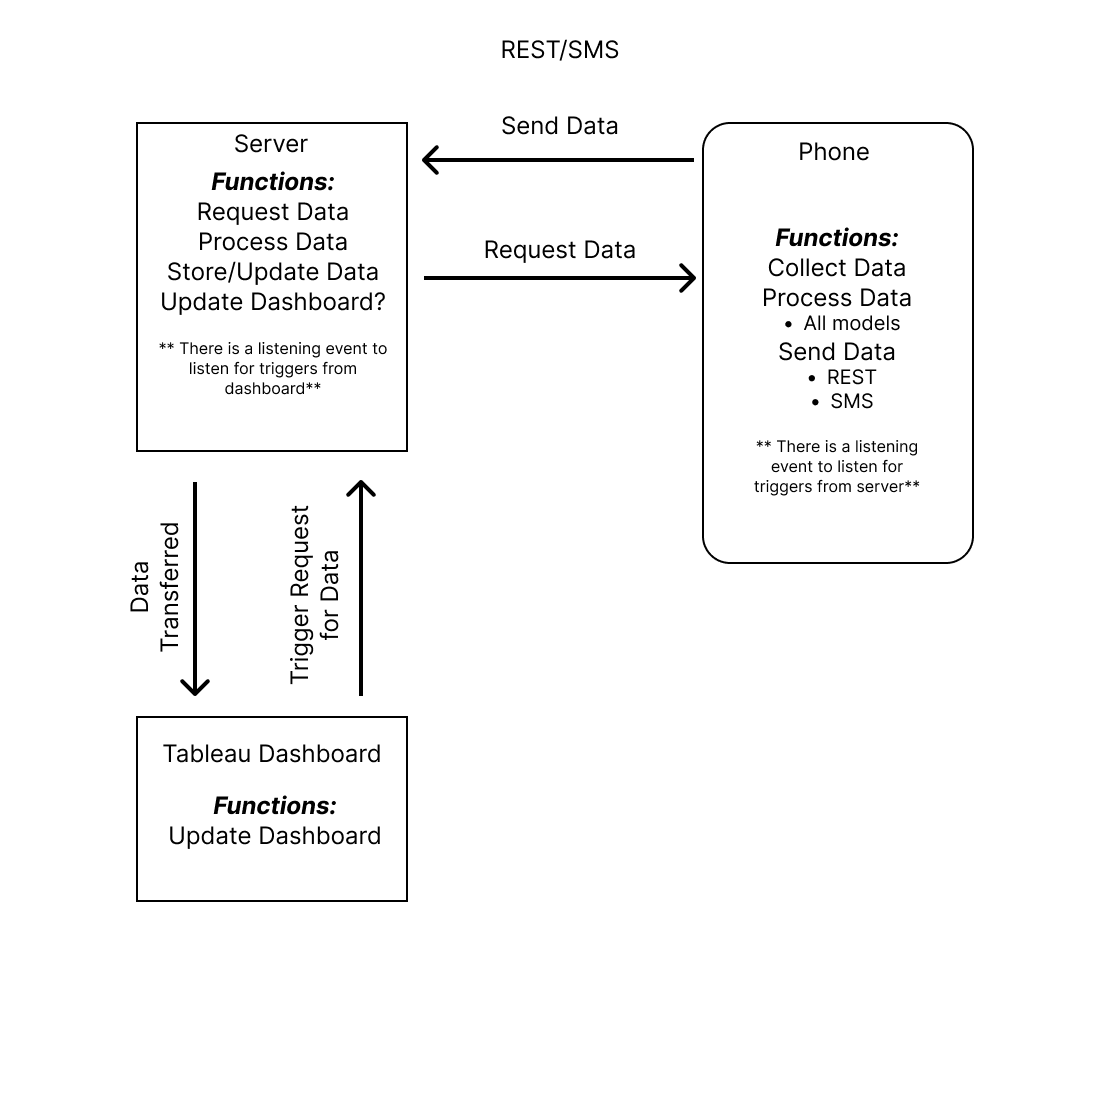

Here is the code for a demo on how it can look like for a real app.

In [74]:
class Phone:
    def __init__(self, user_id):
        self.user_id = user_id  
        self.phone_data = self.get_sensor_data()  # Initializes phone data with sensor data

    def get_sensor_data(self):
        """Simulates fetching sensor data with random values."""
        sensor_data = [pd.Timestamp.now(), f'Sensor_{np.random.randint(1, 10)}', np.random.random(), np.random.random(), np.random.random()]
        return pd.DataFrame([sensor_data], columns=['Timestamp', 'Sensor ID', 'Measurement1', 'Measurement2', 'Measurement3'])

    def collect_data(self, userid):
        """Collects a random data row for a given user."""
        # Ensure the method uses phone_data, not data_df
        user_data = self.phone_data  # No filtering by user_id in this mockup
        return user_data

    def process_data(self, userid, model):
        """Processes data using a specified model."""
        data = self.collect_data(userid)
        processed_data = model(data)
        return processed_data

    def send_data(self, userid, interval, server):
        """Periodically sends data at specified intervals."""
        data = self.collect_data(userid)
        server.store_update_data(data)
        Timer(interval, self.send_data, args=[userid, interval, server]).start()

class Server:
    def __init__(self):
        self.storage_df = pd.DataFrame()  # Separate DataFrame for storing data

    def request_data(self, phone, userid, raw=True):
        """Requests data from the Phone class."""
        if raw:
            return phone.collect_data(userid)
        else:
            return phone.process_data(userid, self.process_data)  # Example: self.process_data as a placeholder

    def process_data(self, data):
        """Processes data."""
        # This is a placeholder for data processing logic, which could involve ML models or other transformations
        processed_data = data  # Simplified for demonstration
        return processed_data

    def store_update_data(self, data):
        """Stores or updates data in a separate DataFrame."""
        self.storage_df = pd.concat([self.storage_df, data], ignore_index=True)




In [75]:
userid="81536B0A-8DBF-4D8A-AC24-9543E2E4C8E0"
phone = Phone(userid)
server = Server()

In [76]:
data_df = phone.collect_data(userid)

In [77]:
raw_data = server.request_data(phone, userid, raw=True)
processed_data = server.request_data(phone, userid, raw=False)
server.store_update_data(raw_data)
server.store_update_data(processed_data)

In [78]:
server.storage_df

,Timestamp,Sensor ID,Measurement1,Measurement2,Measurement3
0,2024-02-26 07:47:02.372085,Sensor_7,0.014555,0.339482,0.709397
1,2024-02-26 07:47:02.372085,Sensor_7,0.014555,0.339482,0.709397
